# Causal Influence Decomposition of the Human Brain Using Multi-site In-silico Perturbation Analysis


In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import warnings
import scipy
import networkx as nx
import seaborn as sns
import utils as ut
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

from tqdm import tqdm
from msapy import msa

from IPython.display import HTML

from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform, cosine
from scipy.special import factorial

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LinearRegression, LassoCV

from sklearn.metrics import r2_score
from netneurotools.metrics import (
    communicability_wei,
    communicability_bin,
    distance_wei_floyd,
)

from visual_config import *
from matplotlib import font_manager


for font in font_manager.findSystemFonts("figures/Atkinson_Typeface/"):
    font_manager.fontManager.addfont(font)

In [3]:
import session_info

session_info.show()

In [4]:
SEED = 2023

sagittal = (0, 180)
axial = (90, 180)
coronal = (0, 90)
bottom = (-90, 0)
size = 80

In [5]:
set_visual_style()

In [6]:
scatter_kw_network = dict(alpha=1, linewidths=0, edgecolors=HALF_BLACK)
scatter_kw = dict(alpha=1, linewidths=0.7, edgecolors=HALF_BLACK)

In [7]:
rng = np.random.default_rng(seed=SEED)
chain = nx.to_numpy_array(nx.generators.path_graph(6, nx.DiGraph())).T


closedchain = chain.copy()
closedchain[0, 5] = 1
closedchain = ut.spectral_normalization(0.9, closedchain)

chain *= 0.9

symmetricchain = nx.to_numpy_array(nx.generators.path_graph(6))
symmetricchain = ut.spectral_normalization(0.9, symmetricchain)

timesteps = 100
example_input = ut.event_maker(6, timesteps)

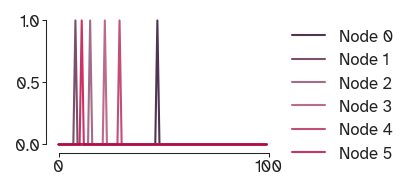

In [8]:
plt.figure(figsize=TINY, dpi=150)
with sns.color_palette(purple_red, n_colors=example_input.shape[0]):
    plt.plot(example_input.T, alpha=0.8)
plt.legend(
    ["Node 0", "Node 1", "Node 2", "Node 3", "Node 4", "Node 5"],
    bbox_to_anchor=(1, 1),
    frameon=False,
)
plt.xticks([0, timesteps])

sns.despine(offset=1, trim=True)

In [9]:
NOISE_STRENGTH = 0.1
DELTA = 0.01
TAU = 0.02
G = 0.74
DURATION = 1
model_params = {"dt": DELTA, "timeconstant": TAU, "coupling": G, "duration": DURATION}

In [10]:
warnings.filterwarnings("ignore")

simple_chain_dynamics = ut.simulate_dynamical_system_parallel(
    adjacency_matrix=chain, input_matrix=example_input, **model_params
)
closed_chain_dynamics = ut.simulate_dynamical_system_parallel(
    adjacency_matrix=closedchain, input_matrix=example_input, **model_params
)
symmetric_chain_dynamics = ut.simulate_dynamical_system_parallel(
    adjacency_matrix=symmetricchain, input_matrix=example_input, **model_params
)

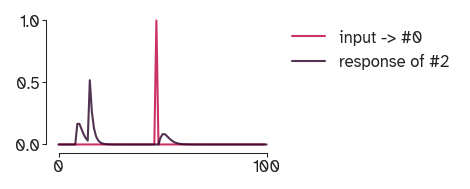

In [11]:
plt.figure(figsize=TINY, dpi=150)

plt.plot(example_input[0], alpha=0.8, color=RED)
plt.plot(simple_chain_dynamics[2], alpha=0.8, color=PURPLEST)

plt.legend(["input -> #0", "response of #2"], bbox_to_anchor=(1, 1), frameon=False)
plt.xticks([0, DURATION / DELTA])
sns.despine(offset=1, trim=True)

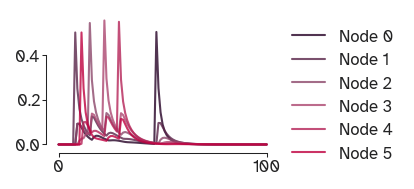

In [12]:
plt.figure(figsize=TINY, dpi=150)
with sns.color_palette(purple_red, n_colors=example_input.shape[0]):
    plt.plot(symmetric_chain_dynamics.T, alpha=0.8)
plt.legend(
    ["Node 0", "Node 1", "Node 2", "Node 3", "Node 4", "Node 5"],
    bbox_to_anchor=(1, 1),
    frameon=False,
)
plt.xticks([0, DURATION / DELTA])
sns.despine(offset=1, trim=True)

In [13]:
cchain = communicability_bin(chain)
cchain[np.diag_indices_from(cchain)] = 0

ccchain = communicability_wei(closedchain)
ccchain[np.diag_indices_from(cchain)] = 0

csychain = communicability_wei(symmetricchain)
csychain[np.diag_indices_from(cchain)] = 0

In [14]:
lesion_params = {
    "adjacency_matrix": chain,
    "input": example_input,
    "model_kwargs": model_params,
}
ci_chain = msa.estimate_causal_influences(
    elements=list(range(len(chain))),
    objective_function=ut.lesion_simple_nodes,
    objective_function_params=lesion_params,
    n_permutations=1_000,
    n_cores=1,
)

lesion_params["adjacency_matrix"] = closedchain
ci_closed_chain = msa.estimate_causal_influences(
    elements=list(range(len(chain))),
    objective_function=ut.lesion_simple_nodes,
    objective_function_params=lesion_params,
    n_permutations=1_000,
    n_cores=1,
)

lesion_params["adjacency_matrix"] = symmetricchain
ci_symmetric_chain = msa.estimate_causal_influences(
    elements=list(range(len(chain))),
    objective_function=ut.lesion_simple_nodes,
    objective_function_params=lesion_params,
    n_permutations=1_000,
    n_cores=1,
)

Doing Nodes:   0%|          | 0/6 [00:00<?, ?it/s]

Doing Nodes:  17%|█▋        | 1/6 [00:01<00:05,  1.07s/it]

Doing Nodes:  33%|███▎      | 2/6 [00:01<00:02,  1.93it/s]

Doing Nodes:  50%|█████     | 3/6 [00:01<00:01,  2.93it/s]

Doing Nodes:  67%|██████▋   | 4/6 [00:01<00:00,  4.03it/s]

Doing Nodes:  83%|████████▎ | 5/6 [00:01<00:00,  4.93it/s]

Doing Nodes:   0%|          | 0/6 [00:00<?, ?it/s]

Doing Nodes:  17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

Doing Nodes:  33%|███▎      | 2/6 [00:00<00:01,  2.50it/s]

Doing Nodes:  50%|█████     | 3/6 [00:01<00:00,  3.54it/s]

Doing Nodes:  67%|██████▋   | 4/6 [00:01<00:00,  4.49it/s]

Doing Nodes:  83%|████████▎ | 5/6 [00:01<00:00,  5.33it/s]

Doing Nodes:   0%|          | 0/6 [00:00<?, ?it/s]

Doing Nodes:  17%|█▋        | 1/6 [00:00<00:00,  7.47it/s]

Doing Nodes:  33%|███▎      | 2/6 [00:00<00:00,  7.65it/s]

Doing Nodes:  50%|█████     | 3/6 [00:00<00:00,  7.79it/s]

Doing Nodes:  67%|██████▋   | 4/6 [00:00<00:00,  7.47it/s]

Doing Nodes:  83%|████████▎ | 5/6 [00:00<00:00,  7.73it/s]

Doing Nodes: 100%|██████████| 6/6 [00:00<00:00,  7.73it/s]


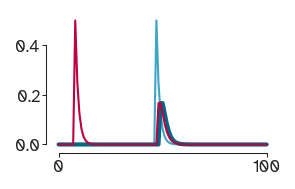

In [15]:
plt.figure(figsize=TINY, dpi=150)
plt.plot(simple_chain_dynamics[0], color=BLUE)
plt.plot(ci_chain[0][1], color=DEEP_BLUE, linewidth=2)  # influence of 0 on 1
plt.plot(simple_chain_dynamics[1], color=RED)
plt.xticks([0, DURATION / DELTA])

sns.despine(offset=1, trim=True)

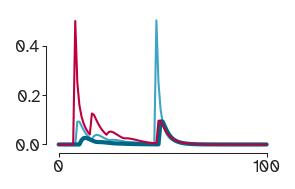

In [16]:
plt.figure(figsize=TINY, dpi=150)
plt.plot(symmetric_chain_dynamics[0], color=BLUE)
plt.plot(ci_symmetric_chain[0][1], color=DEEP_BLUE, linewidth=2)  # influence of 0 on 1
plt.plot(symmetric_chain_dynamics[1], color=RED)
plt.xticks([0, DURATION / DELTA])

sns.despine(offset=1, trim=True)

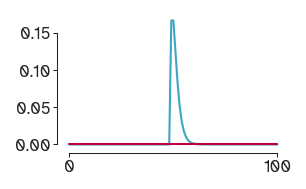

In [17]:
plt.figure(figsize=TINY, dpi=150)
plt.plot(ci_chain[0][1], color=BLUE)  # influence of 0 on 1
plt.plot(ci_chain[1][0], color=RED)
# influence of 1 on 0
plt.xticks([0, DURATION / DELTA])

sns.despine(offset=1, trim=True)

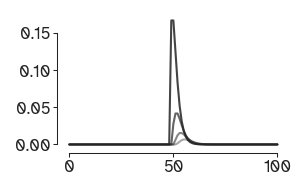

In [18]:
plt.figure(figsize=TINY, dpi=150)
for i in range(5):
    plt.plot(
        ci_chain[0][i], color=HALF_BLACK, alpha=1 - i * 0.15
    )  # influence of 0 over the rest
sns.despine(offset=1, trim=True)

In [19]:
example_modes = ci_symmetric_chain.values.reshape(6, 101, 6)

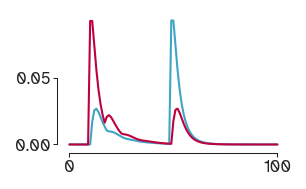

In [20]:
plt.figure(figsize=TINY, dpi=150)

plt.plot(example_modes[1, :, 0], color=BLUE)  # influence of 0 on 1
plt.plot(example_modes[0, :, 1], color=RED)
# influence of 1 on 0
plt.xticks([0, DURATION / DELTA])

sns.despine(offset=1, trim=True)

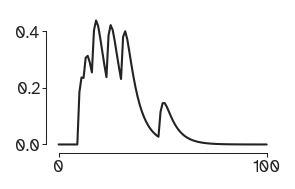

In [21]:
plt.figure(figsize=TINY, dpi=150)
plt.plot(np.nan_to_num(example_modes).sum(axis=0).sum(axis=1), color=HALF_BLACK)
plt.xticks([0, DURATION / DELTA])

sns.despine(offset=1, trim=True)

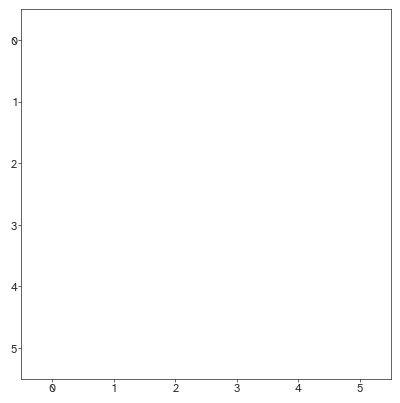

In [22]:
fig, ax = plt.subplots()
heatmaps = [
    [
        plt.imshow(
            example_modes[:, i, :],
            cmap=white_red_mono,
            animated=True,
            vmin=0,
            vmax=np.nan_to_num(example_modes).max(),
        )
    ]
    for i in range(101)
]
anim = animation.ArtistAnimation(fig, heatmaps, interval=60, blit=True)
HTML(anim.to_jshtml())

In [23]:
# f = r"example_causal_contributions.gif"
# writergif = animation.PillowWriter(fps=30)
# anim.save(f, writer=writergif)

In [24]:
ci_chain = ci_chain.groupby(level=0).var().fillna(0)
ci_closed_chain = ci_closed_chain.groupby(level=0).var().fillna(0)
ci_symmetric_chain = ci_symmetric_chain.groupby(level=0).var().fillna(0)

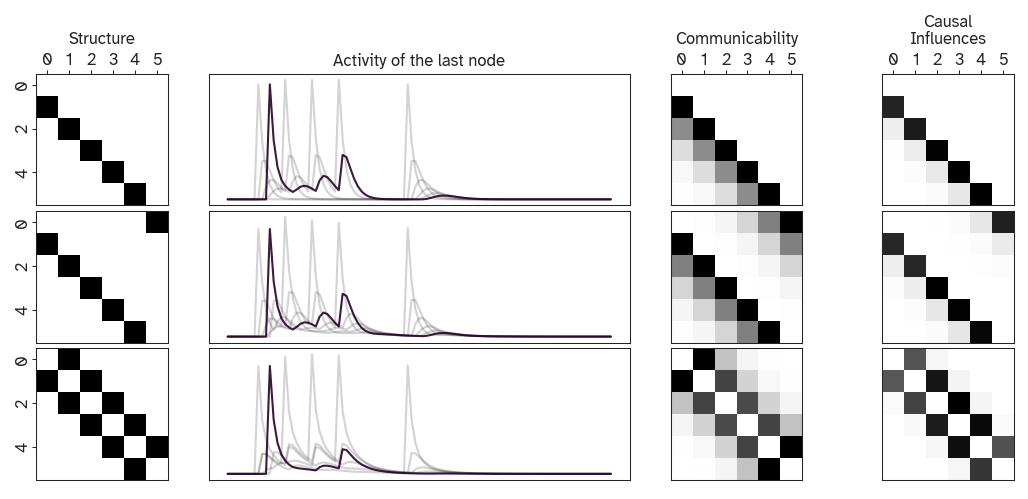

In [25]:
fig, axes = plt.subplot_mosaic(
    [
        ["X", "B", "B", "CX", "CIX"],
        ["Y", "D", "D", "CY", "CIY"],
        ["Z", "F", "F", "CZ", "CIZ"],
    ],
    figsize=(18 * CM, 8 * CM),
    dpi=150,
)

# ===================================== STRUCTURE
sns.heatmap(
    chain, square=True, cmap="binary", cbar=False, ax=axes["X"], linecolor=HALF_BLACK
)

sns.heatmap(
    closedchain,
    square=True,
    cmap="binary",
    cbar=False,
    ax=axes["Y"],
    linecolor=HALF_BLACK,
)

sns.heatmap(
    symmetricchain,
    square=True,
    cmap="binary",
    cbar=False,
    ax=axes["Z"],
    linecolor=HALF_BLACK,
)
# ===================================== COMMUNICABILITY
sns.heatmap(
    cchain, square=True, cmap="binary", cbar=False, ax=axes["CX"], linecolor=HALF_BLACK
)

sns.heatmap(
    ccchain, square=True, cmap="binary", cbar=False, ax=axes["CY"], linecolor=HALF_BLACK
)

sns.heatmap(
    csychain,
    square=True,
    cmap="binary",
    cbar=False,
    ax=axes["CZ"],
    linecolor=HALF_BLACK,
)
# ===================================== CAUSAL INFLUENCE
sns.heatmap(
    ci_chain,
    square=True,
    cmap="binary",
    cbar=False,
    ax=axes["CIX"],
    linecolor=HALF_BLACK,
)

sns.heatmap(
    ci_closed_chain,
    square=True,
    cmap="binary",
    cbar=False,
    ax=axes["CIY"],
    linecolor=HALF_BLACK,
)

sns.heatmap(
    ci_symmetric_chain,
    square=True,
    cmap="binary",
    cbar=False,
    ax=axes["CIZ"],
    linecolor=HALF_BLACK,
)

for ax in ["B", "D", "F"]:
    axes[ax].yaxis.set_visible(False)

for ax in ["B", "D", "Y", "Z"]:
    axes[ax].xaxis.set_visible(False)
for i in range(len(chain)):
    if i < len(chain) - 1:
        axes["B"].plot(simple_chain_dynamics.T[:, i], c=HALF_BLACK, alpha=0.2)
    else:
        axes["B"].plot(simple_chain_dynamics.T[:, i], c=PURPLEST, alpha=(0.9))

for i in range(len(chain)):
    if i < len(chain) - 1:
        axes["D"].plot(closed_chain_dynamics.T[:, i], c=HALF_BLACK, alpha=0.2)
    else:
        axes["D"].plot(closed_chain_dynamics.T[:, i], c=PURPLEST, alpha=(0.9))

for i in range(len(chain)):
    if i < len(chain) - 1:
        axes["F"].plot(symmetric_chain_dynamics.T[:, i], c=HALF_BLACK, alpha=0.2)
    else:
        axes["F"].plot(symmetric_chain_dynamics.T[:, i], c=PURPLEST, alpha=(0.9))

axes["B"].set_title("Activity of the last node", fontsize=8)
axes["X"].set_title("Structure", fontsize=8)
axes["CX"].set_title("Communicability", fontsize=8)
axes["CIX"].set_title("Causal\nInfluences", fontsize=8)

axes["B"].yaxis.tick_right()

for ax in ["X", "CX", "CIX"]:
    axes[ax].xaxis.tick_top()
for ax in ["CY", "CZ", "CIY", "CIZ", "F"]:
    axes[ax].xaxis.set_visible(False)

for ax in ["CX", "CY", "CZ", "CIX", "CIY", "CIZ"]:
    axes[ax].yaxis.set_visible(False)

for ax in axes:
    axes[ax].spines["right"].set_visible(True)
    axes[ax].spines["top"].set_visible(True)
    axes[ax].spines["bottom"].set_visible(True)
    axes[ax].spines["left"].set_visible(True)
fig.tight_layout(pad=0.1)

# plt.savefig(f"chain_propagation.pdf",dpi=600,bbox_inches='tight')

In [26]:
rng = np.random.default_rng(seed=SEED)
erdos_network = nx.to_numpy_array(nx.erdos_renyi_graph(100, 0.35,seed=rng))
barabasi_network = nx.to_numpy_array(nx.barabasi_albert_graph(100, 20,seed=rng))

erdos_network *= rng.lognormal(1, 0.5, size=erdos_network.shape)
barabasi_network *= rng.lognormal(1, 0.5, size=barabasi_network.shape)
barabasi_network[1:21,1:21] += rng.lognormal(0.1, 0.1, size=(20,20))

np.fill_diagonal(barabasi_network,0.)
erdos_network = ut.spectral_normalization(1,erdos_network)
barabasi_network = ut.spectral_normalization(1,barabasi_network)

lognorm_sc_erdos = ut.log_minmax_normalize(erdos_network)
lognorm_sc_barabasi = ut.log_minmax_normalize(barabasi_network)

In [27]:
print(ut.find_density(erdos_network))
print(ut.find_density(barabasi_network))

0.3506
0.358


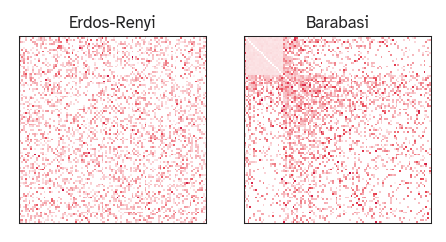

In [28]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=SMALL, dpi=150)

sns.heatmap(erdos_network,cmap=white_red_mono,square=True,xticklabels=False,yticklabels=False,cbar=False,ax=axes["A"])
sns.heatmap(barabasi_network,cmap=white_red_mono,square=True,xticklabels=False,yticklabels=False,cbar=False,ax=axes["B"])
axes["A"].set_title("Erdos-Renyi", fontsize=8)
axes["B"].set_title("Barabasi", fontsize=8)

sns.despine(fig=fig,top=False, right=False, left=False, bottom=False)

In [29]:
SIMULATE = False
if SIMULATE:
    rng = np.random.default_rng(seed=SEED)

    input_noise = rng.normal(0, 2, (100, int(DURATION / DELTA) + 1))

    lesion_params = {
        "adjacency_matrix": ut.spectral_normalization(1,erdos_network),
        "input": input_noise,
        "model_kwargs": model_params,
    }

    ci_erdos = msa.estimate_causal_influences(
        elements=list(range(len(erdos_network))),
        objective_function=ut.lesion_simple_nodes,
        objective_function_params=lesion_params,
        n_permutations=1_000,
        n_cores=-1,
    )
    ci_erdos.to_pickle(f"results/erdos.pickle")

    lesion_params["adjacency_matrix"] = ut.spectral_normalization(1,barabasi_network)
    ci_barabasi = msa.estimate_causal_influences(
        elements=list(range(len(barabasi_network))),
        objective_function=ut.lesion_simple_nodes,
        objective_function_params=lesion_params,
        n_permutations=1_000,
        n_cores=-1,
    )
    ci_barabasi.to_pickle(f"results/barabasi.pickle")


In [30]:
ci_barabasi = pd.read_pickle(f"results/barabasi.pickle").groupby(level=0).var().fillna(0)
barabasi_lognorm_l_ci = ut.log_minmax_normalize(ci_barabasi)
barabasi_direct_influence = pd.DataFrame(barabasi_lognorm_l_ci).where(barabasi_network != 0)

ci_erdos = pd.read_pickle(f"results/erdos.pickle").groupby(level=0).var().fillna(0)
erdos_lognorm_l_ci = ut.log_minmax_normalize(ci_erdos)
erdos_direct_influence = pd.DataFrame(erdos_lognorm_l_ci).where(erdos_network != 0)

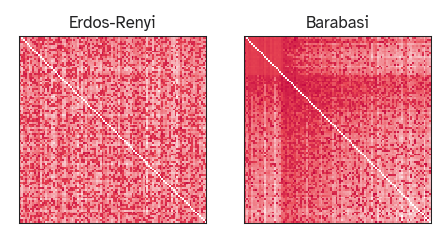

In [31]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=SMALL, dpi=150)

sns.heatmap(erdos_lognorm_l_ci,cmap=white_red_mono,square=True,xticklabels=False,yticklabels=False,cbar=False,ax=axes["A"])
sns.heatmap(barabasi_lognorm_l_ci,cmap=white_red_mono,square=True,xticklabels=False,yticklabels=False,cbar=False,ax=axes["B"])
axes["A"].set_title("Erdos-Renyi", fontsize=8)
axes["B"].set_title("Barabasi", fontsize=8)

sns.despine(fig=fig,top=False, right=False, left=False, bottom=False)

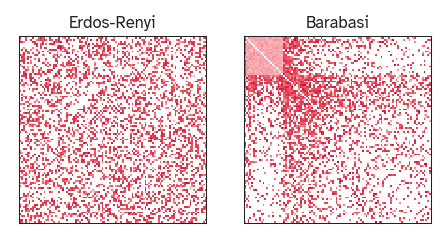

In [32]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=SMALL, dpi=150)

sns.heatmap(lognorm_sc_erdos,cmap=white_red_mono,square=True,xticklabels=False,yticklabels=False,cbar=False,ax=axes["A"])
sns.heatmap(lognorm_sc_barabasi,cmap=white_red_mono,square=True,xticklabels=False,yticklabels=False,cbar=False,ax=axes["B"])
axes["A"].set_title("Erdos-Renyi", fontsize=8)
axes["B"].set_title("Barabasi", fontsize=8)

sns.despine(fig=fig,top=False, right=False, left=False, bottom=False)

Text(0.5, 0, 'Causal Influence')

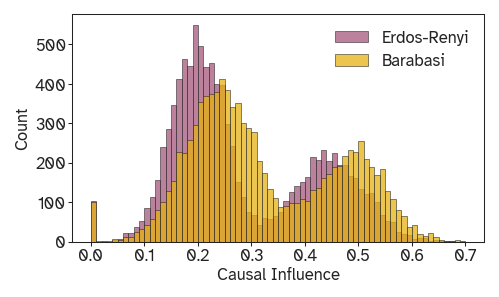

In [33]:
plt.figure(figsize=SMALL,dpi=150)
sns.histplot(erdos_lognorm_l_ci.flatten(),color=PURPLE,binwidth=0.01)
sns.histplot(barabasi_lognorm_l_ci.flatten(),color=YELLOW,binwidth=0.01)
plt.legend(["Erdos-Renyi","Barabasi"],frameon=False)
plt.xlabel("Causal Influence")

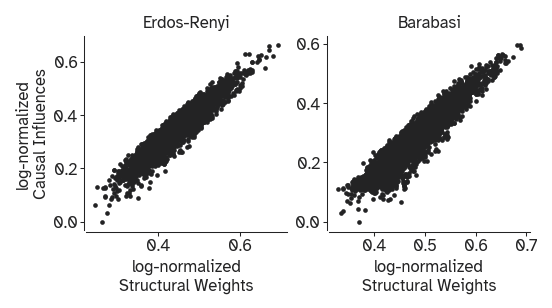

In [34]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=SMALL, dpi=150)

sns.scatterplot(
    x=erdos_lognorm_l_ci.flatten()[erdos_network.flatten() != 0],
    y=lognorm_sc_erdos.flatten()[erdos_network.flatten() != 0],
    s=5,
    linewidth=0,
    ax=axes["A"],
    rasterized=True,
    color=HALF_BLACK
)

sns.scatterplot(
    x=barabasi_lognorm_l_ci.flatten()[barabasi_network.flatten() != 0],
    y=lognorm_sc_barabasi.flatten()[barabasi_network.flatten() != 0],
    s=5,
    linewidth=0,
    ax=axes["B"],
    rasterized=True,
    color=HALF_BLACK,
)
axes["A"].set_ylabel("log-normalized\nCausal Influences", fontsize=8)
axes["A"].set_xlabel("log-normalized\nStructural Weights", fontsize=8)

#axes["B"].set_ylim(0.3,0.8)
axes["B"].set_xlabel("log-normalized\nStructural Weights", fontsize=8)

axes["A"].set_title("Erdos-Renyi", fontsize=8)
axes["B"].set_title("Barabasi", fontsize=8)
sns.despine(fig=fig, offset=1, trim=False)
fig.tight_layout(pad=0.5)

In [35]:
res_parcellation = 2  # zero is low res, two is high res
consensus_mat = scipy.io.loadmat(
    "Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = ut.spectral_normalization(
    1, consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0]
)
fc = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][2]
fiber_lengths = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][1]
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
labels = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][4][:, 0]
fc_modules = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][4][:, 2]

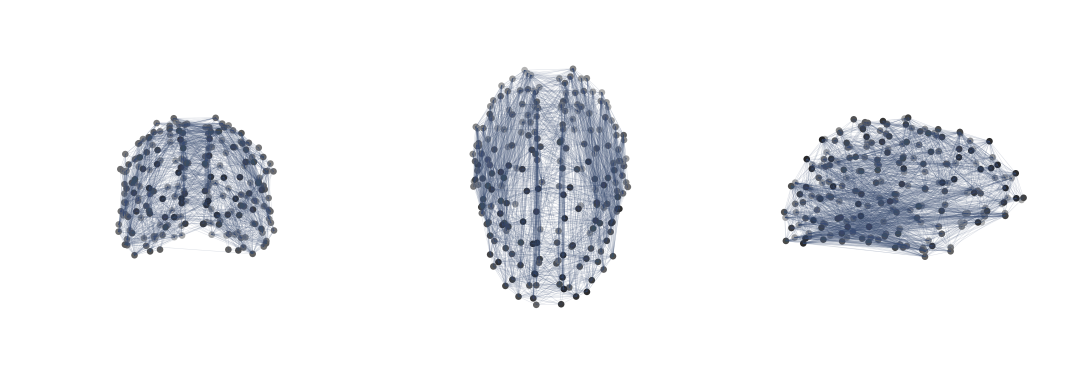

In [36]:
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C"]], figsize=HALF_PAGE, subplot_kw=dict(projection="3d"), dpi=150
)


for i in range(connectivity.shape[0]):
    for j in range(i, connectivity.shape[1]):
        if connectivity[i, j] != 0:
            axes["A"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                c=NIGHT_BLUE,
                alpha=0.2 + connectivity[i, j],
                linewidth=0.2,
            )
            axes["B"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                c=NIGHT_BLUE,
                alpha=0.2 + connectivity[i, j],
                linewidth=0.2,
            )
            axes["C"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                c=NIGHT_BLUE,
                alpha=0.2 + connectivity[i, j],
                linewidth=0.2,
            )

ut.brain_plotter(
    np.array(coordinates[:, 0]),
    coordinates,
    axes["A"],
    view=sagittal,
    size=10,
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)
ut.brain_plotter(
    np.flip(np.array(coordinates[:, 2])),
    coordinates,
    axes["B"],
    view=axial,
    size=10,
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)
ut.brain_plotter(
    np.flip(np.array(coordinates[:, 1])),
    coordinates,
    axes["C"],
    view=coronal,
    size=10,
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)

fig.tight_layout(pad=0.1)
#plt.savefig(f"figures/structural_brain_network.pdf", dpi=600, bbox_inches="tight")

PearsonRResult(statistic=0.23272827255420686, pvalue=0.0)


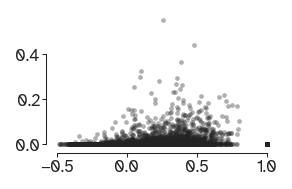

In [37]:
plt.figure(figsize=TINY, dpi=150)
sns.scatterplot(
    x=fc.flatten(),
    y=connectivity.flatten(),
    color=HALF_BLACK,
    s=5,
    linewidth=0,
    alpha=0.2,
)

sns.despine(offset=1, trim=True)

print(pearsonr(fc.flatten(), connectivity.flatten()))

In [38]:
ut.check_symmetric(connectivity)

True

In [39]:
N_NODES = len(connectivity)
communication_mask = np.where(communicability_wei(connectivity) != 0, 1, 0)

In [40]:
rng = np.random.default_rng(seed=SEED)
input_noise = rng.normal(
    0, 2, (N_NODES, int(DURATION / DELTA) + 1)
)  # 2 for tanh and 0.5 for linear
simple_human_dynamics = ut.simulate_dynamical_system_parallel(
    adjacency_matrix=connectivity,
    input_matrix=input_noise,
    function=ut.tanh,
    **model_params
)

([], [])

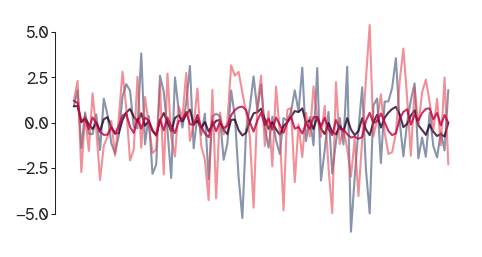

In [41]:
plt.figure(figsize=SMALL, dpi=150)
plt.plot(input_noise[-1], alpha=0.6, color=NIGHT_BLUE)
plt.plot(simple_human_dynamics[-1], alpha=0.8, color=PURPLEST)
plt.plot(input_noise[0], alpha=0.6, color=ORANGE)
plt.plot(simple_human_dynamics[0], alpha=0.8, color=RED)
sns.despine(offset=0, trim=True, bottom=True)
plt.xticks([])

# plt.savefig(f"figures/tanh_example_activity.pdf",dpi=600,bbox_inches='tight')

In [42]:
N_TRIALS = 10
all_trials = np.zeros((len(connectivity), len(connectivity), N_TRIALS))

In [43]:
nonlinear = False
if nonlinear:
    for trial in range(N_TRIALS):
        temp = (
            pd.read_pickle(
                f"results/nonlinear_weighted/causal_modes_nl_w_{len(connectivity)}_{trial}.pickle"
            )
            .groupby(level=0)
            .var()
            .fillna(0)
        )
        all_trials[:, :, trial] = temp

    averaged_ci = all_trials.mean(axis=2)
    averaged_ci = pd.DataFrame(averaged_ci)

else:
    for trial in range(N_TRIALS):
        temp = (
            pd.read_pickle(
                f"results/linear_weighted/causal_modes_l_w_{len(connectivity)}_{trial}.pickle"
            )
            .groupby(level=0)
            .var()
            .fillna(0)
        )
        all_trials[:, :, trial] = temp

    averaged_ci = all_trials.mean(axis=2)
    averaged_ci = pd.DataFrame(averaged_ci)

if res_parcellation == 0:
    averaged_ci = (
        pd.read_pickle(f"results/causal_modes_hopf_68_0.pickle")
        .groupby(level=0)
        .var()
        .fillna(0)
    )

In [44]:
HOPF = False
if HOPF:
    # averaged_ci = pd.read_pickle(f'results/causal_modes_hopf_219_no_delay_longer_T.pickle')
    averaged_ci = pd.read_pickle(f"results/causal_modes_hopf_219_T5.pickle")

    hopf_modes = averaged_ci.values.reshape(219, 5000, 219)
    # hopf_modes = averaged_ci.values.reshape(219,101,219)

    sliced_modes = hopf_modes[:, 1000:, :]
    # sliced_modes = hopf_modes
    averaged_ci = pd.DataFrame(np.nan_to_num(sliced_modes).var(axis=1))

In [45]:
ut.check_symmetric(averaged_ci)

False

In [46]:
diffusion_efficiency = pd.read_csv(
    "results/communication_models/com_mat_DE.txt", header=None
)
navigation_efficiency = pd.read_csv(
    "results/communication_models/com_mat_NE.txt", header=None
)
search_information = pd.read_csv(
    "results/communication_models/com_mat_SI.txt", header=None
)
shortest_path_efficiency = pd.read_csv(
    "results/communication_models/com_mat_SPE.txt", header=None
)

In [47]:
lognorm_ci = ut.minmax_normalize(ut.log_normalize(averaged_ci))
np.fill_diagonal(lognorm_ci, 0.0)

lognorm_comm = ut.minmax_normalize(ut.log_normalize(communicability_wei(connectivity)))
np.fill_diagonal(lognorm_comm, 0.0)

lognorm_sc = ut.minmax_normalize(ut.log_normalize(connectivity))
np.fill_diagonal(lognorm_sc, 0.0)
lognorm_sc = np.where(lognorm_sc != 1, lognorm_sc, 0)
difference = lognorm_ci - lognorm_comm

# scaler = StandardScaler()
# difference = scaler.fit_transform(unscaled_difference)
np.fill_diagonal(difference, 0.0)

difference_outgoing = ut.make_influence_ratio(difference, axis=0)
difference_incoming = ut.make_influence_ratio(difference, axis=1)

difference_direct = pd.DataFrame(difference).where(connectivity != 0)
difference_indirect = pd.DataFrame(difference).where(connectivity == 0)

direct_influence = pd.DataFrame(lognorm_ci).where(connectivity != 0)
indirect_influence = pd.DataFrame(lognorm_ci).where(connectivity == 0)

PearsonRResult(statistic=0.7715768228077934, pvalue=0.0)


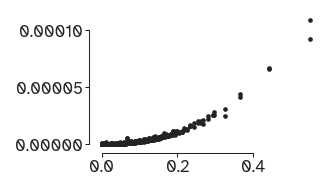

In [48]:
plt.figure(figsize=TINY, dpi=150)
sns.scatterplot(
    x=connectivity.flatten(),
    y=averaged_ci.values.flatten(),
    color=HALF_BLACK,
    s=5,
    linewidth=0,
)
sns.despine(offset=1, trim=True)

print(pearsonr(connectivity.flatten(), averaged_ci.values.flatten()))

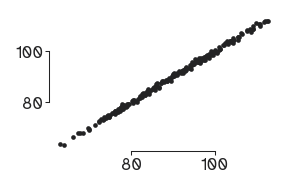

In [49]:
plt.figure(figsize=TINY, dpi=150)
sns.scatterplot(
    x=lognorm_ci.sum(axis=0),
    y=lognorm_ci.sum(axis=1),
    s=5,
    color=HALF_BLACK,
    linewidth=0,
)
sns.despine(offset=0, trim=True)

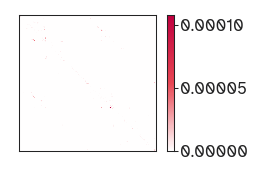

In [50]:
plt.figure(figsize=TINY, dpi=150)

sns.heatmap(
    averaged_ci,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=diverge_from_white,
    linewidths=0,
    center=0,
    linecolor=HALF_BLACK,
)
sns.despine(top=False, right=False, left=False, bottom=False)

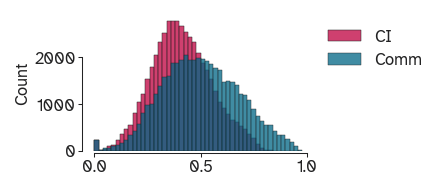

In [51]:
plt.figure(figsize=TINY, dpi=150)
sns.histplot(lognorm_ci.flatten(), binwidth=0.02, color=RED)
sns.histplot(lognorm_comm.flatten(), binwidth=0.02, color=DEEP_BLUE)
sns.despine(offset=1, trim=True)
plt.legend(["CI", "Comm"], bbox_to_anchor=(1, 1), loc=2, frameon=False)
# plt.savefig(f"figures/tanh_CI_CO_hist.pdf",dpi=600,bbox_inches='tight')

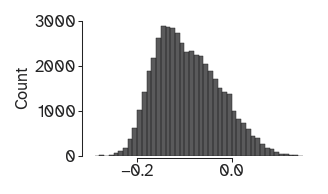

In [52]:
plt.figure(figsize=TINY, dpi=150)
sns.histplot(difference.flatten(), binwidth=0.01, color=HALF_BLACK)
sns.despine(offset=1, trim=True)
# plt.savefig(f"figures/tanh_CI_CO_diff_hist.pdf",dpi=600,bbox_inches='tight')

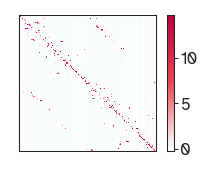

In [53]:
plt.figure(figsize=TINY, dpi=150)

sns.heatmap(
    scipy.stats.zscore(averaged_ci),
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=diverge_from_white,
    linewidths=0,
    center=0,
    linecolor=HALF_BLACK,
)
sns.despine(top=False, right=False, left=False, bottom=False)

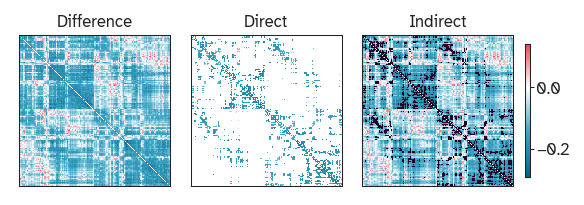

In [54]:
fig, axes = plt.subplot_mosaic([["A", "B", "C"]], figsize=SMALL, dpi=150)
cbar_ax = fig.add_axes([0.99, 0.275, 0.01, 0.45])

sns.heatmap(
    difference,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=diverge_from_white,
    cbar=False,
    ax=axes["A"],
    linewidths=0,
    center=0,
    linecolor=HALF_BLACK,
    vmin=min(difference.flatten()),
    vmax=max(difference.flatten())
)

sns.heatmap(
    difference_direct,
    square=True,
    xticklabels=False,
    yticklabels=False,
    center=0,
    cmap=diverge_from_white,
    cbar=False,
    ax=axes["B"],
    linewidths=0,
    linecolor=HALF_BLACK,
)

sns.heatmap(
    difference_indirect,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=diverge_from_white,
    cbar_ax=cbar_ax,
    ax=axes["C"],
    linewidths=0,
    center=0,
    linecolor=HALF_BLACK,
)

sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)

axes["A"].title.set_text("Difference")
axes["B"].title.set_text("Direct")
axes["C"].title.set_text("Indirect")
axes["C"].set_facecolor(PURPLEST)
fig.tight_layout(pad=1)

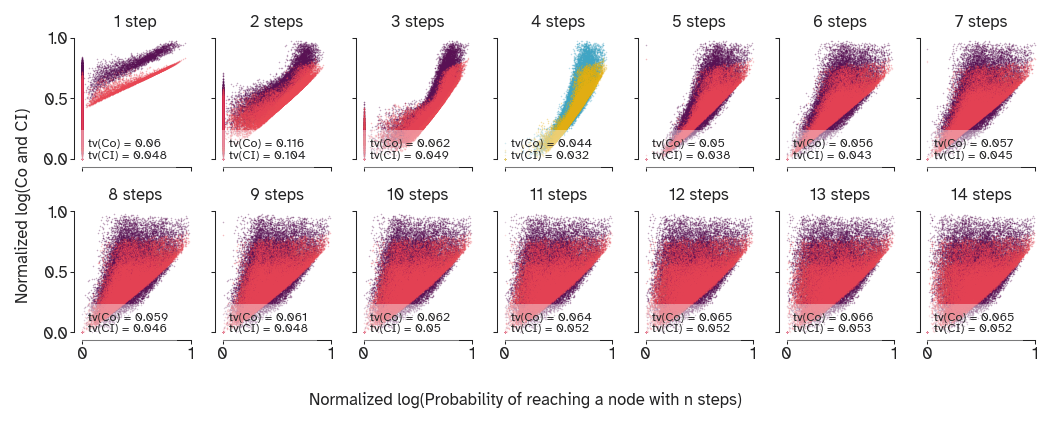

In [55]:
fig, axes = plt.subplots(
    ncols=7, nrows=2, figsize=HALF_PAGE, sharey="row", sharex="col", dpi=150
)

for path, axis in enumerate(axes.ravel()):
    w = np.linalg.matrix_power(connectivity, path + 1)
    w = ut.minmax_normalize(ut.log_normalize(w))
    np.fill_diagonal(w, 0.0)
    w = np.where(w != 1, w, 0)
    total_variance_comm = round(w.var() + lognorm_comm.var(), 3)
    total_variance_ci = round(w.var() + lognorm_ci.var(), 3)

    if path == 3:
        sns.scatterplot(
            x=w.flatten(),
            y=lognorm_comm.flatten(),
            s=0.5,
            linewidth=0,
            alpha=0.2,
            color=BLUE,
            ax=axis,
            rasterized=True,
        )
        sns.scatterplot(
            x=w.flatten(),
            y=lognorm_ci.flatten(),
            s=0.5,
            linewidth=0,
            alpha=0.2,
            color=YELLOW,
            ax=axis,
            rasterized=True,
        )
        sns.despine()

    else:
        sns.scatterplot(
            x=w.flatten(),
            y=lognorm_comm.flatten(),
            s=0.5,
            linewidth=0,
            alpha=0.2,
            color=PURPLER,
            ax=axis,
            rasterized=True,
        )
        sns.scatterplot(
            x=w.flatten(),
            y=lognorm_ci.flatten(),
            s=0.5,
            linewidth=0,
            alpha=0.2,
            color=ORANGE,
            ax=axis,
            rasterized=True,
        )
        sns.despine()

    if path == 0:
        axis.set_title(f"{path+1} step", fontsize=8)
    else:
        axis.set_title(f"{path+1} steps", fontsize=8)
    axis.annotate(
        f"tv(Co) = {total_variance_comm}\ntv(CI) = {total_variance_ci}",
        xy=(0.1, 0.05),
        fontsize=6,
        xycoords="axes fraction",
        bbox=dict(facecolor="white", alpha=0.4, edgecolor="none"),
    )


fig.supxlabel("Normalized log(Probability of reaching a node with n steps)", fontsize=8)
fig.supylabel("Normalized log(Co and CI)", fontsize=8)

sns.despine(offset=1, trim=True)
fig.tight_layout(pad=1)
# plt.savefig(f"figures/tanh_scatter_step_by_steps.pdf",dpi=600,bbox_inches='tight')

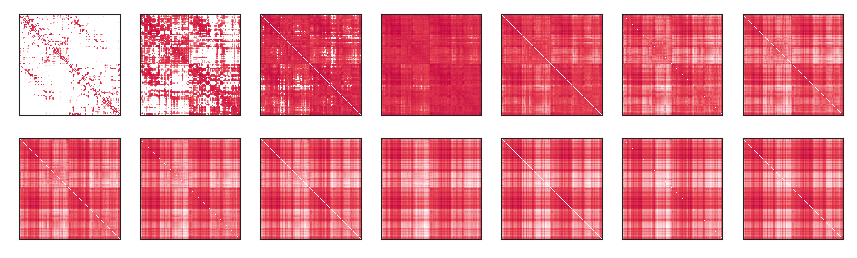

In [56]:
fig, axes = plt.subplots(
    ncols=7, nrows=2, figsize=(18 * CM, 5 * CM), sharey="row", sharex="col", dpi=150
)

for path, axis in enumerate(axes.ravel()):
    w = np.linalg.matrix_power(connectivity, path + 1)
    w = ut.minmax_normalize(ut.log_normalize(w))
    np.fill_diagonal(w, 0.0)
    w = np.where(w != 1, w, 0)
    sns.heatmap(
        w,
        square=True,
        xticklabels=False,
        yticklabels=False,
        cmap=white_red_mono,
        cbar=False,
        ax=axis,
        linewidths=0,
        linecolor=HALF_BLACK,
        rasterized=True,
    )
sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)
# plt.savefig(f"figures/heatmap_step_by_steps.pdf",dpi=600,bbox_inches='tight')

In [57]:
graph_distance = -np.log10(connectivity.copy(order="C"))
shortest_path_distance, _ = distance_wei_floyd(np.abs(graph_distance))

In [58]:
pd.DataFrame({"sp": shortest_path_distance[0], "sc": connectivity[0]}).head(50)

sp        sc
0   0.000000  0.000000
1   1.410852  0.038828
2   0.961313  0.109317
3   1.424446  0.037632
4   2.642278  0.000198
5   3.633832  0.000000
6   2.044944  0.009017
7   1.630775  0.023400
8   2.741469  0.001814
9   2.230999  0.000000
10  3.356689  0.000000
11  3.010694  0.000000
12  4.463959  0.000000
13  5.008866  0.000000
14  4.818581  0.000000
15  4.933860  0.000000
16  4.047432  0.000000
17  3.778946  0.000000
18  2.809095  0.000341
19  3.508401  0.000000
20  4.286827  0.000000
21  3.890337  0.000000
22  3.885725  0.000000
23  4.275283  0.000000
24  4.825843  0.000000
25  5.388162  0.000000
26  4.633000  0.000000
27  5.933091  0.000000
28  5.075666  0.000000
29  4.229494  0.000000
30  4.202736  0.000000
31  4.893927  0.000000
32  5.991995  0.000000
33  6.173399  0.000000
34  5.923266  0.000000
35  5.827488  0.000000
36  5.867842  0.000000
37  5.897840  0.000000
38  6.025826  0.000000
39  3.073797  0.000000
40  3.934000  0.000000
41  5.027740  0.000000
42  5.500083  0.000000
43  5.454317  0.000000
44  3.827122  0.000000
45  5.568673  0.000000
46  5.853862  0.000000
47  4.421724  0.000000
48  4.106945  0.000000
49  5.817934  0.000000

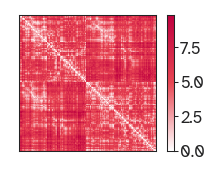

In [59]:
plt.figure(figsize=TINY, dpi=150)

sns.heatmap(
    shortest_path_distance,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    cbar=True,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
)
sns.despine(top=False, right=False, left=False, bottom=False)
# plt.savefig(f"figures/shortest_path_distance_matrix.pdf",dpi=600,bbox_inches='tight')

In [60]:
if HOPF:
    fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=(9 * CM, 3 * CM), dpi=150)
    # influence of [this, :, over this]

    # 0: lateralorbitofrontal
    # 2: lateralorbitofrontal
    # 6: medialorbitofrontal
    # 20: superiorfrontal

    # 9: pars triangularis
    # 44: postcentral
    axes["A"].plot(sliced_modes[0, :, 2], color=NIGHT_BLUE)
    axes["A"].plot(sliced_modes[0, :, 6], color=NIGHT_BLUE, alpha=0.7)
    axes["A"].plot(sliced_modes[0, :, 20], color=PURPLE)

    axes["B"].plot(sliced_modes[0, :, 9], color=PURPLE)
    axes["B"].plot(sliced_modes[0, :, 44], color=PURPLE, alpha=0.7)
    axes["B"].tick_params(
        axis="y", labelright=True, labelleft=False, right=True, left=False
    )

    fig.tight_layout(pad=0.1)
    #plt.savefig(f"figures/HOPF_example_modes.pdf", dpi=600, bbox_inches="tight")

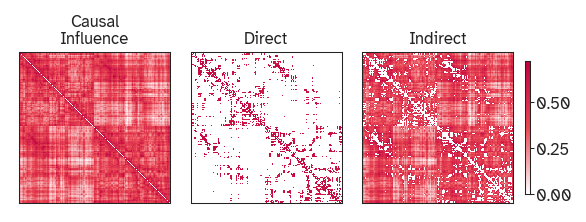

In [61]:
fig, axes = plt.subplot_mosaic([["A", "B", "C"]], figsize=SMALL, dpi=150)
cbar_ax = fig.add_axes([0.99, 0.275, 0.01, 0.45])

sns.heatmap(
    lognorm_ci,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    cbar=False,
    ax=axes["A"],
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
)

sns.heatmap(
    direct_influence,
    square=True,
    xticklabels=False,
    yticklabels=False,
    center=0,
    cmap=white_red_mono,
    cbar=False,
    ax=axes["B"],
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
)

sns.heatmap(
    indirect_influence,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    cbar_ax=cbar_ax,
    ax=axes["C"],
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
)
sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)

axes["A"].title.set_text("Causal\nInfluence")
axes["B"].title.set_text("Direct")
axes["C"].title.set_text("Indirect")
axes["C"].set_facecolor(WHITE)
fig.tight_layout(pad=1)
# plt.savefig(f"figures/tanh_causal_influences.pdf",dpi=600,bbox_inches='tight')

In [62]:
indirect_influence.fillna(0, inplace=True)
direct_influence.fillna(0, inplace=True)


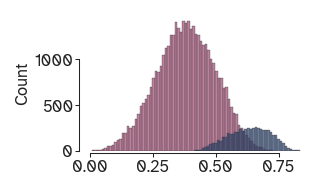

In [63]:
plt.figure(figsize=TINY, dpi=150)
sns.histplot(
    data=indirect_influence.values.flatten()[indirect_influence.values.flatten() != 0],
    binwidth=0.01,
    color=PURPLE,
)
sns.histplot(
    data=direct_influence.values.flatten()[direct_influence.values.flatten() != 0],
    binwidth=0.01,
    color=NIGHT_BLUE,
)
sns.despine(offset=1, trim=True)

In [64]:
influence_gradient = pd.DataFrame(
    ut.minmax_normalize(ut.threshold(5, indirect_influence).sum(0).values), index=labels
)

In [65]:
region_desctiptions = scipy.io.loadmat(
    "Simple-Brain-Plot-main/examples/regionDescriptions.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
correct_labels = region_desctiptions["regionDescriptions"]["lausanne250"]
hemispheres = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][4][:, 3]

In [66]:
sorted_influence_gradient = ut.preprocess_for_surface_plot(
    influence_gradient, hemispheres, correct_labels
)
scipy.io.savemat(
    "hopf_influence_gradient.mat",
    {"influence_gradient": sorted_influence_gradient.values},
)

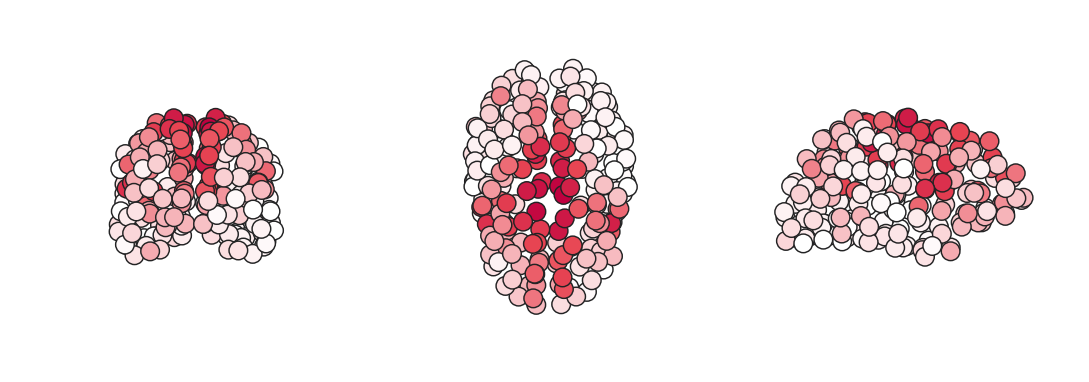

In [67]:
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C"]], figsize=HALF_PAGE, subplot_kw=dict(projection="3d"), dpi=150
)

ut.brain_plotter(
    influence_gradient,
    coordinates,
    axes["A"],
    view=sagittal,
    size=size,
    cmap=white_red_mono,
    scatter_kwargs=scatter_kw,
)
ut.brain_plotter(
    influence_gradient,
    coordinates,
    axes["B"],
    view=axial,
    size=size,
    cmap=white_red_mono,
    scatter_kwargs=scatter_kw,
)
ut.brain_plotter(
    influence_gradient,
    coordinates,
    axes["C"],
    view=coronal,
    size=size,
    cmap=white_red_mono,
    scatter_kwargs=scatter_kw,
)

fig.tight_layout(pad=0.1)
# plt.savefig(f"causal_gradient.pdf",dpi=600,bbox_inches='tight')

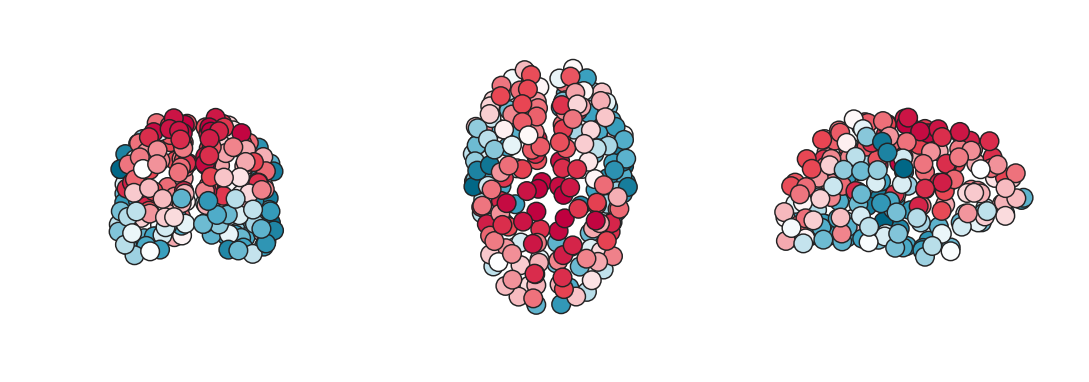

In [68]:
influence_zscore = scipy.stats.zscore(lognorm_ci.sum(axis=1))

fig, axes = plt.subplot_mosaic(
    [["A", "B", "C"]], figsize=HALF_PAGE, subplot_kw=dict(projection="3d"), dpi=150
)

ut.brain_plotter(
    influence_zscore,
    coordinates,
    axes["A"],
    view=sagittal,
    size=size,
    cmap=diverge_from_white,
    scatter_kwargs=scatter_kw,
)
ut.brain_plotter(
    influence_zscore,
    coordinates,
    axes["B"],
    view=axial,
    size=size,
    cmap=diverge_from_white,
    scatter_kwargs=scatter_kw,
)
ut.brain_plotter(
    influence_zscore,
    coordinates,
    axes["C"],
    view=coronal,
    size=size,
    cmap=diverge_from_white,
    scatter_kwargs=scatter_kw,
)

fig.tight_layout(pad=0.1)

In [69]:
influence_zscore_gradient = pd.DataFrame(influence_zscore, index=labels)

In [70]:
spearmanr(influence_gradient.values.flatten(), influence_zscore.flatten())

SignificanceResult(statistic=0.8314577262377973, pvalue=2.653763605239504e-57)

In [71]:
node_degrees = np.where(connectivity, 1, 0).sum(axis=0)

SignificanceResult(statistic=0.5127351494546262, pvalue=4.4127442108677503e-16)

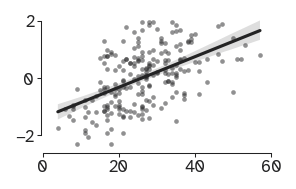

In [72]:
plt.figure(figsize=TINY, dpi=150)
sns.scatterplot(
    y=influence_zscore_gradient.values.flatten(),
    x=node_degrees.flatten(),
    s=5,
    linewidth=0,
    alpha=0.5,
    color=HALF_BLACK,
    rasterized=True,
)
sns.regplot(
    y=influence_zscore_gradient.values.flatten(),
    x=node_degrees.flatten(),
    scatter=False,
    color=HALF_BLACK,
)

plt.xlim(0, 60)
sns.despine(offset=1, trim=True)

spearmanr(influence_zscore_gradient.values.flatten(), node_degrees.flatten())

In [73]:
sorted_zscores = ut.preprocess_for_surface_plot(
    influence_zscore_gradient, hemispheres, correct_labels
)
scipy.io.savemat("hopf_zscore_gradient.mat", {"zscore": sorted_zscores.values})

In [74]:
influence_gradient.sort_values(0, ascending=False).head(20)

0
superiorfrontal          1.000000
posteriorcingulate       0.970621
superiorfrontal          0.939045
superiorfrontal          0.876307
caudalanteriorcingulate  0.839225
superiorfrontal          0.828736
paracentral              0.802146
superiorfrontal          0.799181
paracentral              0.796253
parsopercularis          0.773272
superiorfrontal          0.762461
posteriorcingulate       0.716735
posteriorcingulate       0.707451
paracentral              0.680692
parsopercularis          0.660133
precentral               0.655375
superiorfrontal          0.647418
paracentral              0.584511
caudalanteriorcingulate  0.583171
caudalmiddlefrontal      0.570274

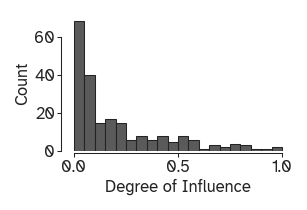

In [75]:
plt.figure(figsize=TINY, dpi=150)
sns.histplot(influence_gradient.values.flatten(), binwidth=0.05, color=HALF_BLACK)
plt.xlabel("Degree of Influence")
sns.despine(offset=1, trim=True)

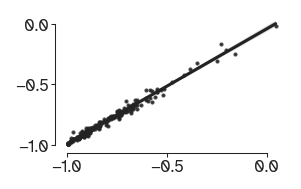

In [76]:
plt.figure(figsize=TINY, dpi=150)
sns.regplot(
    x=difference_outgoing,
    y=difference_incoming,
    fit_reg=True,
    color=HALF_BLACK,
    scatter_kws={"s": 1},
)
sns.despine(offset=1, trim=True)

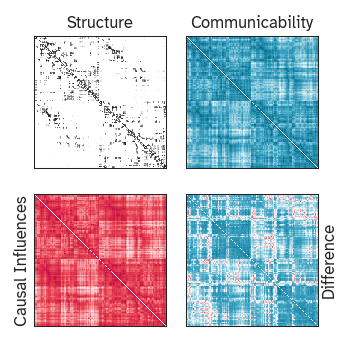

In [77]:
fig, axes = plt.subplot_mosaic(
    [["A", "CA"], ["CI", "DI"]], figsize=(6 * CM, 6 * CM), dpi=150
)

sns.heatmap(
    lognorm_sc,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap="binary",
    cbar=False,
    ax=axes["A"],
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
)
sns.heatmap(
    lognorm_comm,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_blue_mono,
    cbar=False,
    ax=axes["CA"],
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
)

sns.heatmap(
    lognorm_ci,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    cbar=False,
    ax=axes["CI"],
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
)
sns.heatmap(
    difference,
    square=True,
    xticklabels=False,
    yticklabels=False,
    center=0,
    cmap=diverge_from_white,
    cbar=False,
    ax=axes["DI"],
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    vmin=min(difference.flatten()),
    vmax=max(difference.flatten())
)

for ax in axes:
    axes[ax].spines["right"].set_visible(True)
    axes[ax].spines["top"].set_visible(True)
    axes[ax].spines["bottom"].set_visible(True)
    axes[ax].spines["left"].set_visible(True)

axes["A"].title.set_text("Structure")
axes["CA"].title.set_text("Communicability")
axes["CI"].set_ylabel("Causal Influences")
axes["DI"].set_ylabel("Difference")
axes["DI"].yaxis.set_label_position("right")
fig.tight_layout(pad=1)
# plt.savefig(f"figures/tanh_SC_CI_CO_diff.pdf",dpi=600,bbox_inches='tight')

In [78]:
direct_indirect_hue = indirect_influence.where(
    indirect_influence == 0, -1
) + direct_influence.where(direct_influence == 0, 1)

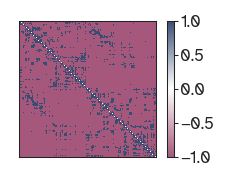

In [79]:
plt.figure(figsize=TINY, dpi=150)

sns.heatmap(
    direct_indirect_hue,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=purples_diverge_from_white,
    linewidths=0,
    center=0,
    linecolor=HALF_BLACK,
)
sns.despine(top=False, right=False, left=False, bottom=False)

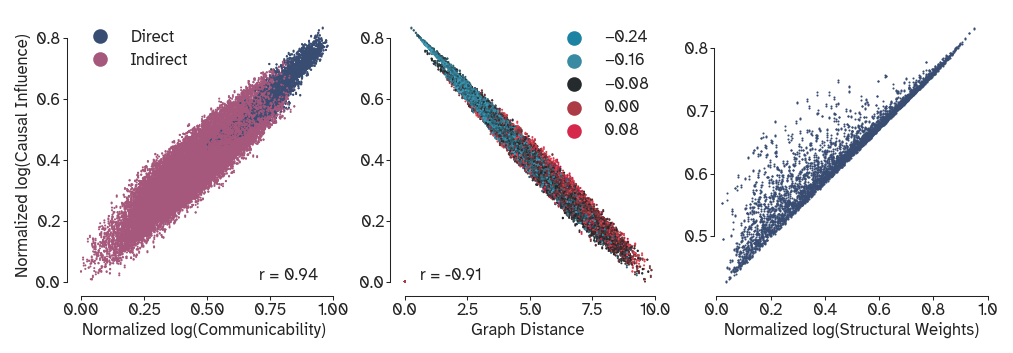

In [80]:
fig, axes = plt.subplot_mosaic([["A", "B", "C"]], figsize=(17 * CM, 6 * CM), dpi=150)
sns.scatterplot(
    x=lognorm_comm.flatten(),
    y=lognorm_ci.flatten(),
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    ax=axes["A"],
    s=1,
    linewidth=0,
    rasterized=True,
)
sns.despine()

new_labels = ["Indirect", "", "Direct"]
for i, text in enumerate(axes["A"].get_legend().get_texts()):
    text.set_text(new_labels[i])

sns.scatterplot(
    x=shortest_path_distance.flatten(),
    y=lognorm_ci.flatten(),
    ax=axes["B"],
    hue=difference.flatten(),
    palette=diverge_from_black,
    s=1,
    linewidth=0,
    rasterized=True,
)
sns.despine()

sns.scatterplot(
    x=lognorm_sc.flatten()[lognorm_sc.flatten() != 0],
    y=direct_influence.values.flatten()[lognorm_sc.flatten() != 0],
    color=NIGHT_BLUE,
    ax=axes["C"],
    s=1,
    linewidth=0,
    rasterized=True,
)
sns.despine()

axes["A"].set_xlabel("Normalized log(Communicability)")
axes["A"].set_ylabel("Normalized log(Causal Influence)")
axes["B"].set_xlabel("Graph Distance")

axes["C"].set_xlabel("Normalized log(Structural Weights)")
fig.tight_layout(pad=1)

axes["A"].annotate(
    f"r = {round(pearsonr(lognorm_comm.flatten(),lognorm_ci.flatten())[0],2)}",
    color=HALF_BLACK,
    xy=(0.7, 0.05),
    xycoords="axes fraction",
)
axes["B"].annotate(
    f"r = {round(pearsonr(shortest_path_distance.flatten(),lognorm_ci.flatten())[0],2)}",
    color=HALF_BLACK,
    xy=(0.1, 0.05),
    xycoords="axes fraction",
)


handles = [
    plt.plot(
        [],
        [],
        color=NIGHT_BLUE,
        marker=".",
        linestyle="",
        markersize=12,
        label="Direct",
    )[0],
    plt.plot(
        [], [], color=PURPLE, marker=".", linestyle="", markersize=12, label="Indirect"
    )[0],
]
axes["A"].legend(handles=handles, loc="upper left", frameon=False, fontsize=8)
axes["B"].legend(frameon=False, fontsize=8)
axes["C"].set_xlim(0, 1)

axes["C"].legend().set_visible(False)
sns.despine(fig=fig, offset=1, trim=True)

# plt.savefig(f"figures/tanh_scatter_CI_GD_SC.pdf",dpi=600,bbox_inches='tight')

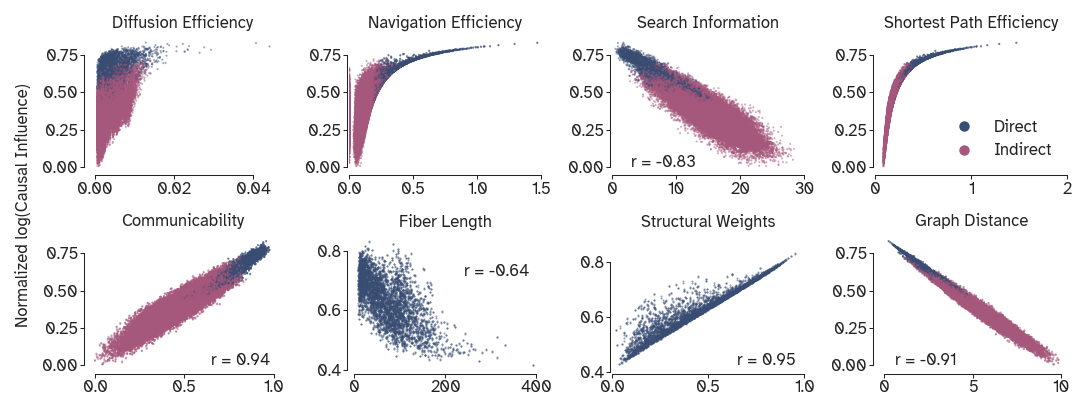

In [81]:
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C", "D"], ["E", "F", "G", "H"]], figsize=HALF_PAGE, dpi=150
)

sns.scatterplot(
    x=diffusion_efficiency.values.flatten(),
    y=lognorm_ci.flatten(),
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    ax=axes["A"],
    s=1,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)

sns.scatterplot(
    x=navigation_efficiency.values.flatten(),
    y=lognorm_ci.flatten(),
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    ax=axes["B"],
    s=1,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)

sns.scatterplot(
    x=search_information.values.flatten(),
    y=lognorm_ci.flatten(),
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    ax=axes["C"],
    s=1,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)

sns.scatterplot(
    x=shortest_path_efficiency.values.flatten(),
    y=lognorm_ci.flatten(),
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    ax=axes["D"],
    s=1,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)

sns.scatterplot(
    x=lognorm_comm.flatten(),
    y=lognorm_ci.flatten(),
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    ax=axes["E"],
    s=1,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)

sns.scatterplot(
    x=fiber_lengths[fiber_lengths != 0].flatten(),
    y=lognorm_ci[fiber_lengths != 0].flatten(),
    color=NIGHT_BLUE,
    ax=axes["F"],
    s=1,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)

sns.scatterplot(
    x=lognorm_sc.flatten()[lognorm_sc.flatten() != 0],
    y=direct_influence.values.flatten()[lognorm_sc.flatten() != 0],
    color=NIGHT_BLUE,
    ax=axes["G"],
    s=1,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)

sns.scatterplot(
    x=shortest_path_distance.flatten(),
    y=lognorm_ci.flatten(),
    ax=axes["H"],
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    s=1,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)


axes["A"].set_title("Diffusion Efficiency", fontsize=8)
axes["B"].set_title("Navigation Efficiency", fontsize=8)
axes["C"].set_title("Search Information", fontsize=8)
axes["D"].set_title("Shortest Path Efficiency", fontsize=8)
axes["E"].set_title("Communicability", fontsize=8)
axes["F"].set_title("Fiber Length", fontsize=8)
axes["G"].set_title("Structural Weights", fontsize=8)
axes["H"].set_title("Graph Distance", fontsize=8)

for ax in ["A", "B", "C", "E", "H"]:
    axes[ax].legend().remove()

axes["C"].annotate(
    f"r = {round(pearsonr(np.nan_to_num(search_information.values.flatten(),0),lognorm_ci.flatten())[0],2)}",
    color=HALF_BLACK,
    xy=(0.1, 0.05),
    xycoords="axes fraction",
)

axes["E"].annotate(
    f"r = {round(pearsonr(lognorm_comm.flatten(),lognorm_ci.flatten())[0],2)}",
    color=HALF_BLACK,
    xy=(0.65, 0.05),
    xycoords="axes fraction",
)

axes["F"].annotate(
    f"r = {round(pearsonr(fiber_lengths[fiber_lengths!=0].flatten(),lognorm_ci[fiber_lengths!=0].flatten())[0],2)}",
    color=HALF_BLACK,
    xy=(0.6, 0.7),
    xycoords="axes fraction",
)

axes["G"].annotate(
    f"r = {round(pearsonr(lognorm_sc.flatten()[lognorm_sc.flatten()!=0],direct_influence.values.flatten()[lognorm_sc.flatten()!=0])[0],2)}",
    color=HALF_BLACK,
    xy=(0.65, 0.05),
    xycoords="axes fraction",
)

axes["H"].annotate(
    f"r = {round(pearsonr(shortest_path_distance.flatten(),lognorm_ci.flatten())[0],2)}",
    color=HALF_BLACK,
    xy=(0.1, 0.05),
    xycoords="axes fraction",
)

fig.text(
    -0.01,
    0.5,
    "Normalized log(Causal Influence)",
    va="center",
    rotation="vertical",
    fontsize=8,
)

handles = [
    plt.plot(
        [], [], color=NIGHT_BLUE, marker=".", linestyle="", markersize=8, label="Direct"
    )[0],
    plt.plot(
        [], [], color=PURPLE, marker=".", linestyle="", markersize=8, label="Indirect"
    )[0],
]
axes["D"].legend(handles=handles, loc="lower right", frameon=False, fontsize=8)

axes["B"].set_xlim(0, 1.5)
axes["C"].set_xlim(0, 30)
axes["D"].set_xlim(0, 2)


axes["G"].set_ylim(0.4, 0.9)
axes["G"].set_xlim(0, 1)


sns.despine(fig=fig, offset=1, trim=True)
fig.tight_layout(pad=1)
# plt.savefig(f"figures/tanh_Communication_models_CI.pdf",dpi=600,bbox_inches='tight')

In [82]:
euclidean_distances = squareform(pdist(coordinates)).flatten()

In [83]:
sar_parameter_space = list(
    ParameterGrid(
        {
            "omega": np.linspace(0.01, 1.0, 20).round(
                2,
            )
        }
    )
)
for parameters in tqdm(
    sar_parameter_space, total=len(sar_parameter_space), desc="Optimizing hyperparams: "
):
    estimated_ci = ut.sar_model(adjacency_matrix=connectivity, omega=parameters["omega"])
    sar = ut.log_minmax_normalize(estimated_ci)
    r = np.corrcoef(lognorm_ci.flatten(), sar.flatten())[0, 1]
    parameters.update({"correlation": r})


Optimizing hyperparams:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing hyperparams: 100%|██████████| 20/20 [00:00<00:00, 52.04it/s]


In [84]:
sar_optimum_params = max(sar_parameter_space, key=lambda x: x["correlation"])
sar_optimum_params

{'omega': 0.43, 'correlation': 0.9984295831058476}

In [85]:
sar = ut.sar_model(adjacency_matrix=connectivity, omega=sar_optimum_params['omega'])
lognorm_sar = ut.log_minmax_normalize(sar)

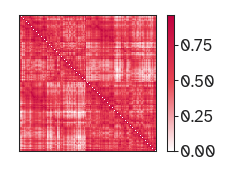

In [86]:
plt.figure(figsize=TINY, dpi=150)
sns.heatmap(
    ut.log_minmax_normalize(sar),
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
)

sns.despine(top=False, right=False, left=False, bottom=False)
# plt.savefig(f"figures/tanh_SAR_CI_fit_matrix.pdf",dpi=600,bbox_inches='tight')

Text(0.05, 0.9, 'r = 0.998')

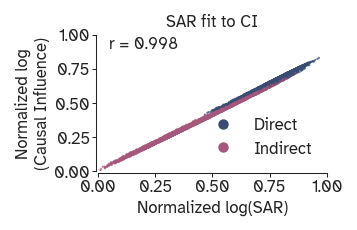

In [87]:
plt.figure(figsize=TINY, dpi=150)
sns.scatterplot(
    x=lognorm_sar.flatten(),
    y=lognorm_ci.flatten(),
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    s=1,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)
plt.xlim(0, 1)
plt.ylim(0, 1)

sns.despine(offset=1, trim=True)
plt.legend(handles=handles, loc="lower right", frameon=False, fontsize=8)
plt.xlabel("Normalized log(SAR)")
plt.ylabel("Normalized log\n(Causal Influence)")
plt.title("SAR fit to CI")
plt.annotate(
    f"r = {round(pearsonr(lognorm_sar.flatten(),lognorm_ci.flatten())[0],3)}",
    xy=(0.05, 0.9),
    xycoords="axes fraction",
)

Text(0.05, 0.9, 'r = 0.94')

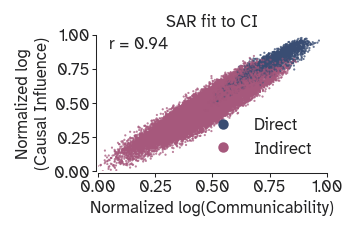

In [88]:
plt.figure(figsize=TINY, dpi=150)
sns.scatterplot(
    x=lognorm_sar.flatten(),
    y=lognorm_comm.flatten(),
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    s=1,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)
plt.xlim(0, 1)
plt.ylim(0, 1)

sns.despine(offset=1, trim=True)
plt.legend(handles=handles, loc="lower right", frameon=False, fontsize=8)

plt.xlabel("Normalized log(Communicability)")
plt.ylabel("Normalized log\n(Causal Influence)")
plt.title("SAR fit to CI")
plt.annotate(
    f"r = {round(pearsonr(lognorm_sar.flatten(),lognorm_comm.flatten())[0],2)}",
    xy=(0.05, 0.9),
    xycoords="axes fraction",
)

In [89]:
for parameters in tqdm(
    sar_parameter_space, total=len(sar_parameter_space), desc="Optimizing hyperparams: "
):
    fc = ut.sar_model(adjacency_matrix=connectivity, omega=parameters["omega"])
    sar_comm = ut.log_minmax_normalize(fc)
    r = np.corrcoef(lognorm_comm.flatten(), sar_comm.flatten())[0, 1]
    parameters.update({"comm_correlation": r})
sar_comm_optimum_params = max(sar_parameter_space, key=lambda x: x["comm_correlation"])
sar_comm_optimum_params

Optimizing hyperparams: 100%|██████████| 20/20 [00:00<00:00, 75.34it/s]


{'omega': 0.06,
 'correlation': 0.9707575123541506,
 'comm_correlation': 0.9752228198979934}

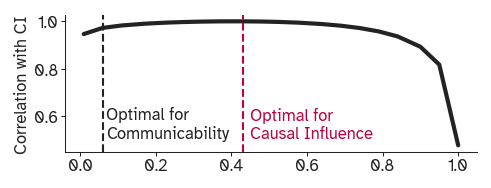

In [90]:
rs = [parameters["correlation"] for parameters in sar_parameter_space]
plt.figure(figsize=(9 * CM, 3 * CM), dpi=150)
plt.plot(
    np.linspace(0.01, 1.0, 20).round(
        2,
    ),
    rs,
    color=HALF_BLACK,
    linewidth=2,
)
plt.axvline(0.06, color=HALF_BLACK, linestyle="--")
plt.axvline(0.43, color=RED, linestyle="--")
plt.annotate(
    "Optimal for\nCommunicability",
    xy=(0.1, 0.1),
    xycoords="axes fraction",
    color=HALF_BLACK,
)
plt.annotate(
    "Optimal for\nCausal Influence", xy=(0.45, 0.1), xycoords="axes fraction", color=RED
)
plt.ylabel("Correlation with CI")
sns.despine(offset=0.1, trim=False)


In [91]:
difference_sar = lognorm_ci - lognorm_sar
np.fill_diagonal(difference_sar, 0.0)

In [92]:
sar_comm = ut.sar_model(adjacency_matrix=connectivity, omega=0.06)
lognorm_sar_comm = ut.log_minmax_normalize(sar_comm)

Text(0.05, 0.9, 'r = 0.97')

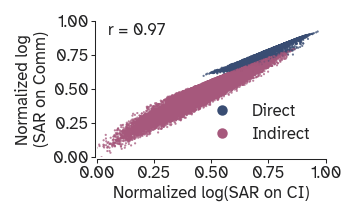

In [93]:
plt.figure(figsize=TINY, dpi=150)
sns.scatterplot(
    x=lognorm_sar.flatten(),
    y=lognorm_sar_comm.flatten(),
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    s=1,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)
plt.xlim(0, 1)
plt.ylim(0, 1)

sns.despine(offset=1, trim=True)
plt.legend(handles=handles, loc="lower right", frameon=False, fontsize=8)

plt.xlabel("Normalized log(SAR on CI)")
plt.ylabel("Normalized log\n(SAR on Comm)")
plt.annotate(
    f"r = {round(pearsonr(lognorm_sar.flatten(),lognorm_sar_comm.flatten())[0],2)}",
    xy=(0.05, 0.9),
    xycoords="axes fraction",
)

Text(0.05, 0.9, 'r = 0.98')

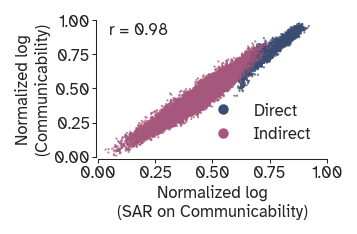

In [94]:
plt.figure(figsize=TINY, dpi=150)
sns.scatterplot(
    x=lognorm_sar_comm.flatten(),
    y=lognorm_comm.flatten(),
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    s=1,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)
plt.xlim(0, 1)
plt.ylim(0, 1)

sns.despine(offset=1, trim=True)
plt.legend(handles=handles, loc="lower right", frameon=False, fontsize=8)

plt.xlabel("Normalized log\n(SAR on Communicability)")
plt.ylabel("Normalized log\n(Communicability)")
plt.annotate(
    f"r = {round(pearsonr(lognorm_sar_comm.flatten(),lognorm_comm.flatten())[0],2)}",
    xy=(0.05, 0.9),
    xycoords="axes fraction",
)

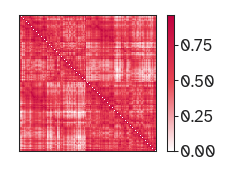

In [95]:
plt.figure(figsize=TINY, dpi=150)
sns.heatmap(
    lognorm_sar,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
)

sns.despine(top=False, right=False, left=False, bottom=False)
# plt.savefig(f"figures/tanh_SAR_CI_fit_matrix.pdf",dpi=600,bbox_inches='tight')

In [96]:
communicability_parameter_space = list(ParameterGrid({"scaling": np.linspace(0.01, 3, 20).round(2,)}))

for parameters in tqdm(
    communicability_parameter_space, total=len(communicability_parameter_space), desc="Optimizing hyperparams: "
):
    estimated_ci = ut.parametrized_communicability(adjacency_matrix=connectivity, scaling=parameters["scaling"])
    commm = ut.log_minmax_normalize(estimated_ci)
    r = np.corrcoef(lognorm_ci.flatten(), commm.flatten())[0, 1]
    parameters.update({"comm_correlation": r})
commm_optimum_params = max(communicability_parameter_space, key=lambda x: x["comm_correlation"])
commm_optimum_params

Optimizing hyperparams: 100%|██████████| 20/20 [00:01<00:00, 11.22it/s]


{'scaling': 2.21, 'comm_correlation': 0.9436562158736946}

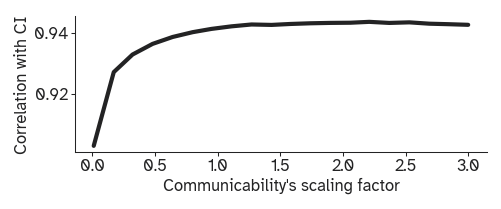

In [97]:
rs = [parameters["comm_correlation"] for parameters in communicability_parameter_space]

plt.figure(figsize=(9 * CM, 3 * CM), dpi=150)
plt.plot(np.linspace(0.01, 3, 20).round(2,),rs,
    color=HALF_BLACK,
    linewidth=2,
)

plt.ylabel("Correlation with CI")
plt.xlabel("Communicability's scaling factor")

sns.despine(offset=0.1, trim=False)

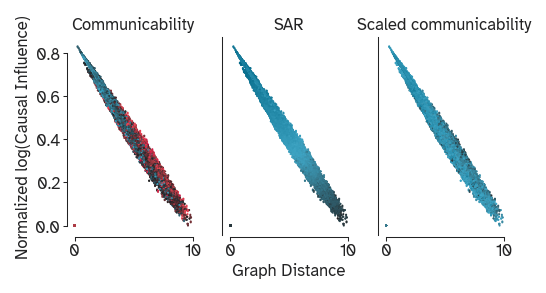

In [98]:
estimated_ci = ut.parametrized_communicability(adjacency_matrix=connectivity, scaling=commm_optimum_params['scaling'])
estimated_ci = ut.log_minmax_normalize(estimated_ci)
difference_comm = lognorm_ci - lognorm_comm

fig, axes = plt.subplot_mosaic([["A", "B", "C"]], figsize=SMALL, dpi=150)

sns.scatterplot(
    x=shortest_path_distance.flatten(),
    y=lognorm_ci.flatten(),
    ax=axes["A"],
    hue=difference.flatten(),
    palette=diverge_from_black,
    s=1,
    linewidth=0,
    rasterized=True,
)


sns.scatterplot(
    x=shortest_path_distance.flatten(),
    y=lognorm_ci.flatten(),
    ax=axes["B"],
    hue=difference_sar.flatten(),
    palette=black_blue_mono.reversed(),
    s=1,
    linewidth=0,
    rasterized=True,
)

sns.scatterplot(
    x=shortest_path_distance.flatten(),
    y=lognorm_ci.flatten(),
    ax=axes["C"],
    hue=difference_comm.flatten(),
    palette=black_blue_mono.reversed(),
    s=1,
    linewidth=0,
    rasterized=True,
)

axes["A"].set_ylabel("Normalized log(Causal Influence)")
axes["A"].set_title("Communicability")
axes["A"].legend().remove()

axes["B"].set_xlabel("Graph Distance")
axes["B"].set_yticks([])
axes["B"].legend().remove()
axes["B"].set_title("SAR")

axes["C"].set_yticks([])
axes["C"].legend().remove()
axes["C"].set_title("Scaled communicability")
sns.despine(fig=fig, offset=1, trim=True)
fig.tight_layout(pad=1)

In [99]:
X = (
    pd.DataFrame(
        {
            "diffusion_efficiency": diffusion_efficiency.values.flatten(),
            "navigation_efficiency": navigation_efficiency.values.flatten(),
            "search_information": search_information.values.flatten(),
            "shortest_path_efficiency": shortest_path_efficiency.values.flatten(),
            "communicability": lognorm_comm.flatten(),
            "graph_distance": graph_distance.flatten(),
            "structural_weight": lognorm_sc.flatten(),
            "fiber_length": fiber_lengths.flatten(),
            "fc": fc.flatten(),
            "euclidean_distance": squareform(pdist(coordinates)).flatten(),
            "sar": lognorm_sar.flatten(),
        }
    )
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)
y = (
    pd.DataFrame({"causal_influence": lognorm_ci.flatten()})
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

In [100]:
omegas = np.linspace(0.0, 1.0, 50).round(
    2,
)
sars = np.zeros((connectivity.shape[0], connectivity.shape[0], len(omegas)))
for i, omega in enumerate(omegas):
    sar = ut.sar_model(adjacency_matrix=connectivity, omega=omega)
    lognorm_sar = ut.log_minmax_normalize(sar)
    sars[:, :, i] = lognorm_sar

In [101]:
n_trials = 25
reg_contributions = np.zeros((n_trials, X.shape[1], len(omegas)))
scores = np.zeros((n_trials, len(omegas)))
for omega in range(len(omegas)):
    X["sar"] = sars[:, :, omega].flatten()
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    for trial in tqdm(range(n_trials), desc="Lassoing like a boss", total=n_trials):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, random_state=SEED + trial, test_size=0.3, shuffle=True
        )

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)

        scaler = StandardScaler()
        X_test = scaler.fit_transform(X_test)

        lasso_model = LassoCV(cv=10, random_state=SEED, n_alphas=100, n_jobs=-1).fit(
            X_train, y_train
        )
        scores[trial, omega] = lasso_model.score(X_test, y_test)
        reg_contributions[trial, :, omega] = (
            np.abs(lasso_model.coef_) / np.abs(lasso_model.coef_).sum()
        ) * 100

Lassoing like a boss: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


In [102]:
reg_contributions_over_omega = pd.DataFrame(
    reg_contributions.mean(axis=0), index=X.columns, columns=omegas
)
sorted_conts = reg_contributions_over_omega.loc[
    reg_contributions_over_omega.mean(axis=1).sort_values().index
]

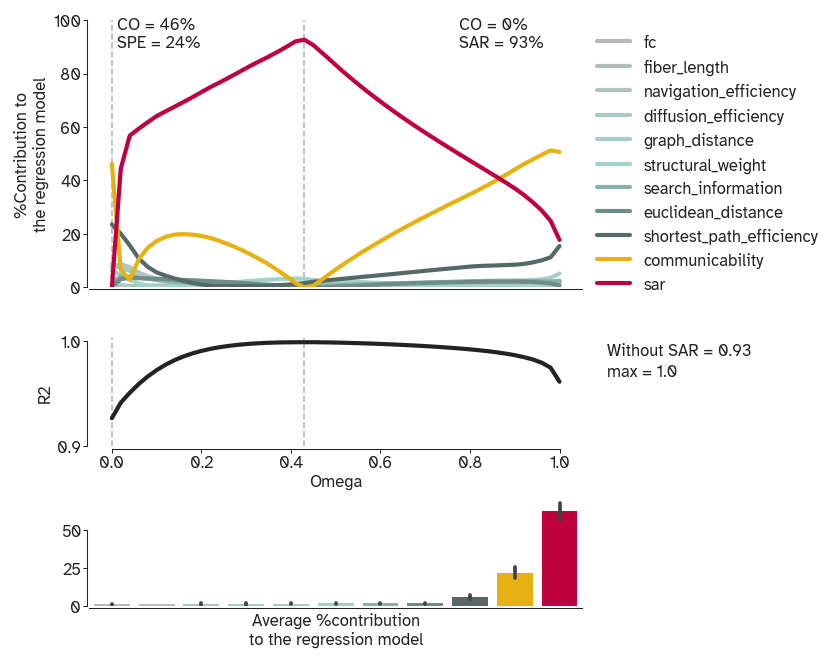

In [103]:
boring_map = sns.blend_palette(
    [GRAY, SLOW_GREEN, HALF_BLACK], n_colors=sorted_conts.shape[0]
)
sorted_palette = [boring_map[i] for i in range(len(sorted_conts.index))]

fig, axes = plt.subplot_mosaic(
    [
        ["A", "A", "A", "A"],
        ["A", "A", "A", "A"],
        ["B", "B", "B", "B"],
        ["X", "X", "X", "X"],
    ],
    figsize=(14 * CM, 11 * CM),
    dpi=150,
)
axes["B"].axvline(
    omegas[np.argmax(scores.mean(axis=0))], color=GRAY, linestyle="--", linewidth=0.8
)
axes["A"].axvline(
    omegas[np.argmax(scores.mean(axis=0))], color=GRAY, linestyle="--", linewidth=0.8
)
axes["A"].axvline(0, color=GRAY, linestyle="--", linewidth=0.8)
axes["B"].axvline(0, color=GRAY, linestyle="--", linewidth=0.8)

for indx, contribution in enumerate(sorted_conts.index):
    if contribution == "sar":
        axes["A"].plot(
            sorted_conts.loc[contribution], linewidth=2, label=contribution, color=RED
        )
    elif contribution == "communicability":
        axes["A"].plot(
            sorted_conts.loc[contribution],
            linewidth=2,
            label=contribution,
            color=YELLOW,
        )
    else:
        axes["A"].plot(
            sorted_conts.loc[contribution],
            linewidth=2,
            label=contribution,
            color=boring_map[indx],
        )

axes["X"] = sns.barplot(data=sorted_conts.T, orient="v", palette=sorted_palette)
axes["X"].containers[0].get_children()[-1].set_facecolor(RED)
axes["X"].containers[0].get_children()[-2].set_facecolor(YELLOW)


axes["A"].set_xticks([])
axes["A"].legend(
    loc="lower center", bbox_to_anchor=(0.4, 0.12), frameon=False, fontsize=5
)
sns.move_legend(axes["A"], "upper left", bbox_to_anchor=(1, 1))

axes["A"].set_ylabel("%Contribution to\nthe regression model")

axes["B"].plot(omegas, scores.mean(axis=0), HALF_BLACK, linewidth=2)

axes["B"].set_yticks([0.9, 1.0])
axes["B"].set_xticks(list(np.linspace(0, 1, 6)))

axes["B"].set_xlabel("Omega")
axes["B"].set_ylabel("R2")
axes["X"].set_xticks([])
axes["X"].set_xlabel("Average %contribution\nto the regression model")

axes["B"].annotate(
    f"max = {round(scores.mean(axis=0).max(),2)}",
    color=HALF_BLACK,
    xy=(1.05, 0.65),
    xycoords="axes fraction",
)

axes["B"].annotate(
    f"Without SAR = {round(scores.mean(axis=0)[0],2)}",
    color=HALF_BLACK,
    xy=(1.05, 0.85),
    xycoords="axes fraction",
)

optimal_comm_cont = round(
    sorted_conts[omegas[np.argmax(scores.mean(axis=0))]]["communicability"]
)
optimal_sar_cont = round(sorted_conts[omegas[np.argmax(scores.mean(axis=0))]]["sar"])

sarless_comm_cont = round(sorted_conts[0]["communicability"])
sarless_sp_cont = round(sorted_conts[0]["shortest_path_efficiency"])

axes["A"].annotate(
    f"CO = {sarless_comm_cont}%\nSPE = {sarless_sp_cont}%",
    color=HALF_BLACK,
    xy=(0.055, 0.9),
    xycoords="axes fraction",
)

axes["A"].annotate(
    f"CO = {optimal_comm_cont}%\nSAR = {optimal_sar_cont}%",
    color=HALF_BLACK,
    xy=(0.75, 0.9),
    xycoords="axes fraction",
)
axes["A"].set_ylim(0, 100)


sns.despine(fig=fig, offset=1, trim=True)
fig.tight_layout(pad=0.5)
# plt.savefig(f"figures/tanh_multivariate_over_omega.pdf",dpi=600,bbox_inches='tight')

In [104]:
X_paths = {}
for path in range(14):
    w = np.linalg.matrix_power(connectivity, path + 1)
    w = ut.minmax_normalize(ut.log_normalize(w))
    np.fill_diagonal(w, 0.0)
    w = np.where(w != 1, w, 0)
    X_paths[path + 1] = w.flatten()
X_paths = pd.DataFrame(X_paths).replace([np.inf, -np.inf], np.nan).fillna(0)
X_paths.shape

(47961, 14)

In [105]:
n_trials = 100

path_contributions = np.zeros((n_trials, X_paths.shape[1]))
path_scores = np.zeros((n_trials))
for trial in tqdm(
    range(n_trials), desc="Me? pff, nothing, just walking around", total=n_trials
):
    X_train, X_test, y_train, y_test = train_test_split(
        X_paths, y, random_state=SEED + trial, test_size=0.3, shuffle=True
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)

    lasso_model = LassoCV(cv=10, random_state=SEED, n_alphas=100, n_jobs=-1).fit(
        X_train, y_train
    )
    path_scores[trial] = lasso_model.score(X_test, y_test)
    path_contributions[trial, :] = (
        np.abs(lasso_model.coef_) / np.abs(lasso_model.coef_).sum()
    ) * 100

Me? pff, nothing, just walking around:   0%|          | 0/100 [00:00<?, ?it/s]

Me? pff, nothing, just walking around: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


In [106]:
X_paths = {}
for path in range(14):
    if path == 0:
        X_paths[path] = connectivity.flatten()
    else:
        w = np.linalg.matrix_power(connectivity, path)
        w = ut.minmax_normalize(ut.log_normalize(w))
        np.fill_diagonal(w, 0.0)
        w = np.where(w != 1, w, 0)
        w = w / factorial(path)
        X_paths[path] = w.flatten()
X_paths = pd.DataFrame(X_paths).replace([np.inf, -np.inf], np.nan).fillna(0)
X_paths.shape

(47961, 14)

In [107]:
power_scores = np.zeros((X_paths.columns.shape[0], n_trials))
for trial in tqdm(
    range(n_trials), desc="(I'm Not Your) Steppin' Stone", total=n_trials
):
    for step in X_paths.columns:
        if step == 0:
            X = X_paths.copy()[step].values.reshape(-1, 1)
        else:
            X += (X_paths[step].values).reshape(-1, 1)
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, lognorm_ci.flatten())
        power_scores[step, trial] = linear_regressor.score(X, lognorm_ci.flatten())

(I'm Not Your) Steppin' Stone:   6%|▌         | 6/100 [00:00<00:03, 27.64it/s]

(I'm Not Your) Steppin' Stone: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


In [108]:
power_score = pd.DataFrame(power_scores)

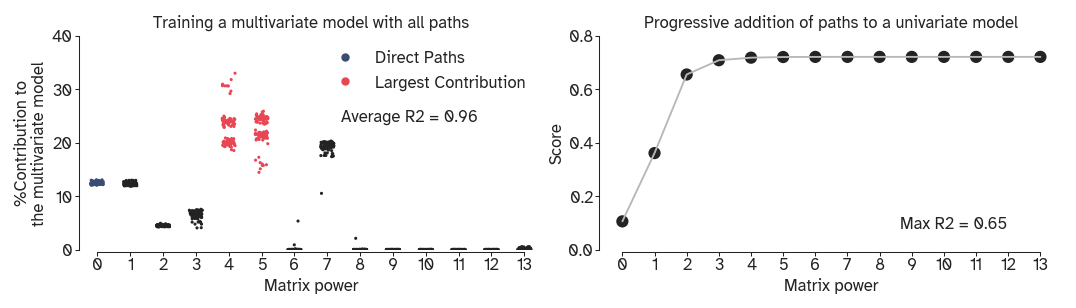

In [109]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=(18 * CM, 5 * CM), dpi=150)
dot_colors = [
    NIGHT_BLUE,
    HALF_BLACK,
    HALF_BLACK,
    HALF_BLACK,
    ORANGE,
    ORANGE,
    HALF_BLACK,
    HALF_BLACK,
    HALF_BLACK,
    HALF_BLACK,
    HALF_BLACK,
    HALF_BLACK,
    HALF_BLACK,
    HALF_BLACK,
]
sns.stripplot(
    data=path_contributions, palette=dot_colors, size=1.5, jitter=0.2, ax=axes["A"]
)
axes["A"].annotate(
    f"Average R2 = {round(path_scores.mean(),2)}",
    color=HALF_BLACK,
    xy=(0.565, 0.6),
    xycoords="axes fraction",
)
axes["B"].annotate(
    f"Max R2 = {round(power_score.mean().max(),2)}",
    color=HALF_BLACK,
    xy=(0.65, 0.1),
    xycoords="axes fraction",
)

axes["A"].set_xlabel("Matrix power")

axes["B"].set_xlabel("Matrix power")
axes["A"].set_ylabel("%Contribution to\nthe multivariate model")

sns.pointplot(data=power_score.T, ax=axes["B"], color=HALF_BLACK, join=False)
sns.pointplot(data=power_score.T, ax=axes["B"], color=GRAY, markers="", scale=0.5)

axes["B"].set_ylabel("Score")
axes["B"].set_title("Progressive addition of paths to a univariate model")
axes["A"].set_title("Training a multivariate model with all paths")


handles = [
    plt.plot(
        [],
        [],
        color=NIGHT_BLUE,
        marker=".",
        linestyle="",
        markersize=6,
        label="Direct Paths",
    )[0],
    plt.plot(
        [],
        [],
        color=ORANGE,
        marker=".",
        linestyle="",
        markersize=6,
        label="Largest Contribution",
    )[0],
]
axes["A"].legend(handles=handles, loc="upper right", frameon=False, fontsize=8)
axes["A"].set_ylim(0, 40)
axes["B"].set_ylim(0, 0.8)
sns.despine(fig=fig, offset=1, trim=True)
plt.tight_layout(pad=0.5)
# plt.savefig(f"figures/tanh_step_uni_multivariate.pdf",dpi=600,bbox_inches='tight')

In [110]:
linear_regressor = LinearRegression()
linear_regressor.fit(
    lognorm_sc.flatten()[lognorm_sc.flatten() != 0].reshape(-1, 1),
    direct_influence.values.flatten()[lognorm_sc.flatten() != 0],
)
Y_pred = linear_regressor.predict(
    lognorm_sc.flatten()[lognorm_sc.flatten() != 0].reshape(-1, 1)
)
residuals = direct_influence.values.flatten()[lognorm_sc.flatten() != 0] - Y_pred

In [111]:
residual_matrix = lognorm_sc.copy()
residual_matrix[residual_matrix != 0] = residuals

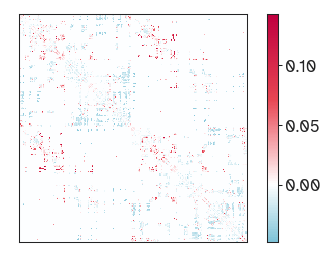

In [112]:
plt.figure(figsize=SMALL, dpi=150)
sns.heatmap(
    residual_matrix,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=diverge_from_white,
    linewidths=0,
    linecolor=HALF_BLACK,
    center=0,
    rasterized=True,
)
sns.despine(top=False, right=False, left=False, bottom=False)
# plt.savefig(f"figures/tanh_residual_matrix.pdf",dpi=600,bbox_inches='tight')

In [113]:
residual_matrix.max()

0.14265032671163969

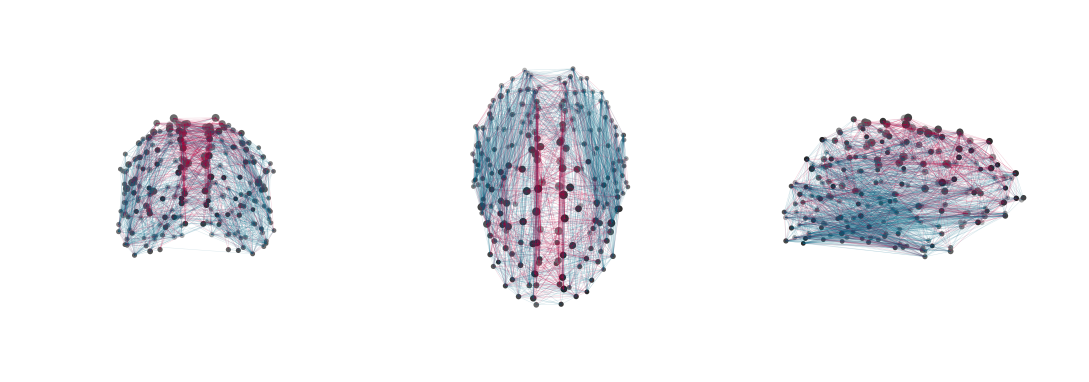

In [114]:
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C"]], figsize=HALF_PAGE, subplot_kw=dict(projection="3d"), dpi=150
)
for i in range(residual_matrix.shape[0]):
    for j in range(i, residual_matrix.shape[1]):
        if residual_matrix[i, j] > 0:
            axes["A"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                color=RED,
                alpha=0.2 + residual_matrix[i, j],
                linewidth=0.2,
            )
            axes["B"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                color=RED,
                alpha=0.2 + residual_matrix[i, j],
                linewidth=0.2,
            )
            axes["C"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                color=RED,
                alpha=0.2 + residual_matrix[i, j],
                linewidth=0.2,
            )
        elif residual_matrix[i, j] < 0:
            axes["A"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                color=DEEP_BLUE,
                alpha=0.2 + residual_matrix[i, j],
                linewidth=0.2,
            )
            axes["B"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                color=DEEP_BLUE,
                alpha=0.2 + residual_matrix[i, j],
                linewidth=0.2,
            )
            axes["C"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                color=DEEP_BLUE,
                alpha=0.2 + residual_matrix[i, j],
                linewidth=0.2,
            )

ut.brain_plotter(
    np.array(coordinates[:, 0]),
    coordinates,
    axes["A"],
    view=sagittal,
    size=5+12*(influence_gradient),
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)
ut.brain_plotter(
    np.flip(np.array(coordinates[:, 2])),
    coordinates,
    axes["B"],
    view=axial,
    size=5+12*(influence_gradient),
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)
ut.brain_plotter(
    np.flip(np.array(coordinates[:, 1])),
    coordinates,
    axes["C"],
    view=coronal,
    size=5+12*(influence_gradient),
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)

fig.tight_layout(pad=0.1)
plt.savefig(f"figures/residuals_on_brain.pdf", dpi=600, bbox_inches="tight")

In [115]:
vcenter = 0
vmin, vmax = residuals.min(), residuals.max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)

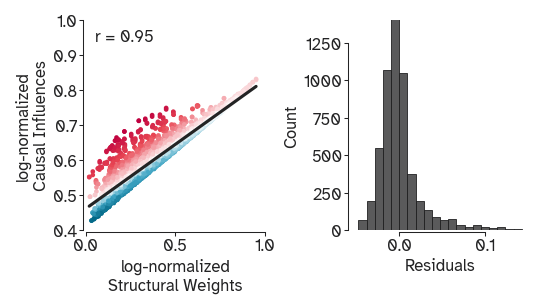

In [116]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=SMALL, dpi=150)

sns.scatterplot(
    x=lognorm_sc.flatten()[lognorm_sc.flatten() != 0],
    y=direct_influence.values.flatten()[lognorm_sc.flatten() != 0],
    hue=residual_matrix.flatten()[lognorm_sc.flatten() != 0],
    palette=diverge_from_white,
    s=5,
    hue_norm=normalize,
    linewidth=0,
    ax=axes["A"],
    rasterized=True,
)
sns.regplot(
    x=lognorm_sc.flatten()[lognorm_sc.flatten() != 0],
    y=direct_influence.values.flatten()[lognorm_sc.flatten() != 0],
    scatter=False,
    color=HALF_BLACK,
    ax=axes["A"],
)

sns.histplot(residuals, bins=20, color=HALF_BLACK, ax=axes["B"])

axes["A"].set_ylabel("log-normalized\nCausal Influences", fontsize=8)
axes["A"].set_xlabel("log-normalized\nStructural Weights", fontsize=8)
axes["B"].set_xlabel("Residuals", fontsize=8)

axes["A"].annotate(
    f"r = {round(pearsonr(lognorm_sc.flatten()[lognorm_sc.flatten()!=0],direct_influence.values.flatten()[lognorm_sc.flatten()!=0])[0],2)}",
    color=HALF_BLACK,
    xy=(0.05, 0.9),
    xycoords="axes fraction",
    fontsize=8,
)
axes["A"].legend(frameon=False)
axes["A"].set_ylim(0.4, 1)
axes["A"].set_xlim(0.0, 1)
axes["B"].set_ylim(0, 1400)
axes["A"].legend().remove()

sns.despine(fig=fig, offset=1, trim=True)

fig.tight_layout(pad=0.5)
# plt.savefig(f"figures/tanh_residual_scatter.pdf",dpi=600,bbox_inches='tight')

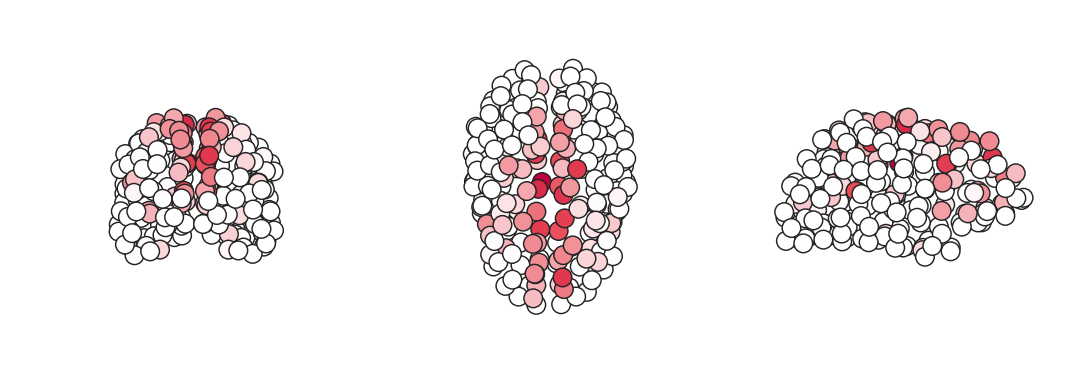

In [117]:
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C"]], figsize=HALF_PAGE, subplot_kw=dict(projection="3d"), dpi=150
)

ut.brain_plotter(
    np.clip(residual_matrix.sum(axis=0), a_min=0, a_max=None),
    coordinates,
    axes["A"],
    view=sagittal,
    size=size,
    cmap=white_red_mono,
    scatter_kwargs=scatter_kw,
)
ut.brain_plotter(
    np.clip(residual_matrix.sum(axis=0), a_min=0, a_max=None),
    coordinates,
    axes["B"],
    view=axial,
    size=size,
    cmap=white_red_mono,
    scatter_kwargs=scatter_kw,
)
ut.brain_plotter(
    np.clip(residual_matrix.sum(axis=0), a_min=0, a_max=None),
    coordinates,
    axes["C"],
    view=coronal,
    size=size,
    cmap=white_red_mono,
    scatter_kwargs=scatter_kw,
)
fig.tight_layout(pad=0.1)

In [118]:
residual_gradient = pd.DataFrame(residual_matrix.sum(axis=0), index=labels)

In [119]:
sorted_residuals = ut.preprocess_for_surface_plot(
    residual_gradient, hemispheres, correct_labels
)
scipy.io.savemat(
    "hopf_residual_gradient.mat", {"residual_gradient": sorted_residuals.values}
)

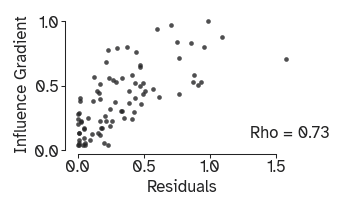

In [120]:
plt.figure(figsize=TINY, dpi=150)
positive_residuals = np.clip(residual_matrix.sum(axis=0), a_min=0, a_max=None)
sns.scatterplot(
    x=positive_residuals[positive_residuals != 0],
    y=influence_gradient.values.squeeze()[positive_residuals != 0],
    color=HALF_BLACK,
    s=5,
    linewidth=0,
    alpha=0.8,
)
plt.xlabel("Residuals", fontsize=8)
plt.ylabel("Influence Gradient", fontsize=8)
ig_vs_res = spearmanr(
    positive_residuals[positive_residuals != 0],
    influence_gradient.values.squeeze()[positive_residuals != 0],
)[0]
plt.annotate(
    f"Rho = {round(ig_vs_res,2)}",
    color=HALF_BLACK,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    xy=(0.8, 0.1),
    xycoords="axes fraction",
    fontsize=8,
)
sns.despine(offset=1, trim=True)
# plt.savefig(f"figures/tanh_residual_vs_influence_gradient.pdf",dpi=600,bbox_inches='tight')

In [121]:
spearmanr(
    positive_residuals[positive_residuals != 0],
    influence_gradient.values.squeeze()[positive_residuals != 0],
)

SignificanceResult(statistic=0.7277715905639364, pvalue=4.430430786152529e-15)

In [122]:
communicability_binarized = communicability_bin(np.where(connectivity > 0, 1, 0))

In [124]:
G = nx.from_numpy_array(connectivity)
closeness_c = 1/shortest_path_distance.mean(axis=0)

degree_c = list(nx.degree_centrality(G).values())
eigen_vector_c = list(nx.eigenvector_centrality(G,weight='weight').values())
second_order_c = 1/np.array(list(nx.second_order_centrality(G).values()))
coreness = np.load(
    "results/Consensus_Connectomes_coreness.npy", allow_pickle=True
).item()
coreness = np.array(list(coreness.values()))

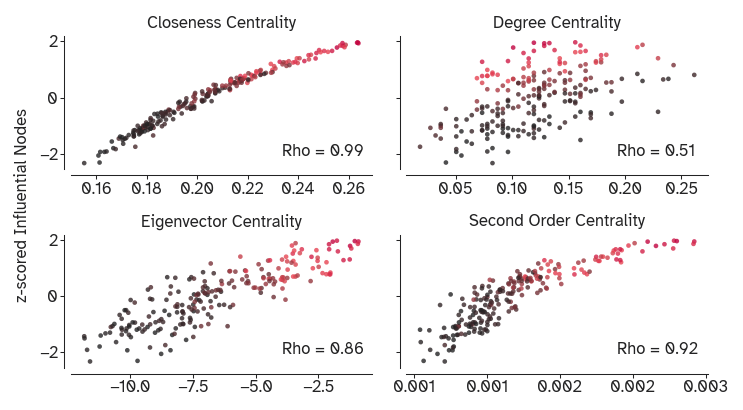

In [125]:
fig, axes = plt.subplot_mosaic(
    [["A", "B",],
     ["C", "D",]], figsize=(12*CM,7*CM), dpi=150
)

sns.scatterplot(
    x=closeness_c,
    y=influence_zscore,
    hue=influence_gradient.squeeze(),
    palette=black_red_mono,
    ax=axes["A"],
    s=5,
    linewidth=0,
    alpha=0.8,
    rasterized=True,
)
axes["A"].set_title("Closeness Centrality", fontsize=8)


sns.scatterplot(
    x=degree_c,
    y=influence_zscore,
    hue=influence_gradient.squeeze(),
    palette=black_red_mono,
    ax=axes["B"],
    s=5,
    linewidth=0,
    alpha=0.8,
    rasterized=True,
)
axes["B"].set_title("Degree Centrality", fontsize=8)

sns.scatterplot(
    x=ut.log_normalize(eigen_vector_c),
    y=influence_zscore,
    hue=influence_gradient.squeeze(),
    palette=black_red_mono,
    ax=axes["C"],
    s=5,
    linewidth=0,
    alpha=0.8,
    rasterized=True,
)
axes["C"].set_title("Eigenvector Centrality", fontsize=8)

sns.scatterplot(
    x=second_order_c,
    y=influence_zscore,
    hue=influence_gradient.squeeze(),
    palette=black_red_mono,
    ax=axes["D"],
    s=5,
    linewidth=0,
    alpha=0.8,
    rasterized=True,
)
axes["D"].set_title("Second Order Centrality", fontsize=8)

axes["A"].annotate(
    f"Rho = {round(spearmanr(closeness_c,influence_zscore)[0],2)}",
    fontsize=8,
    color=HALF_BLACK,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    xy=(0.7, 0.1),
    xycoords="axes fraction",
)


axes["B"].annotate(
    f"Rho = {round(spearmanr(degree_c,influence_zscore)[0],2)}",
    fontsize=8,
    color=HALF_BLACK,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    xy=(0.7, 0.1),
    xycoords="axes fraction",
)

axes["C"].annotate(
    f"Rho = {round(spearmanr(ut.log_normalize(eigen_vector_c),influence_zscore)[0],2)}",
    fontsize=8,
    color=HALF_BLACK,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    xy=(0.7, 0.1),
    xycoords="axes fraction",
)

axes["D"].annotate(
    f"Rho = {round(spearmanr(second_order_c,influence_zscore)[0],2)}",
    fontsize=8,
    color=HALF_BLACK,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    xy=(0.7, 0.1),
    xycoords="axes fraction",
)


for ax in ["A", "B", "C", "D"]:

    axes[ax].legend().remove()
axes['D'].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))

for ax in ["B", "D"]:
    axes[ax].set_yticklabels([])
fig.text(
    -0.01,
    0.5,
    "z-scored Influential Nodes",
    va="center",
    rotation="vertical",
    fontsize=8,
)


sns.despine(fig=fig, offset=3, trim=False)
fig.tight_layout(pad=1)
plt.savefig(f"figures/linear_CI_centralities.pdf",dpi=600,bbox_inches='tight')

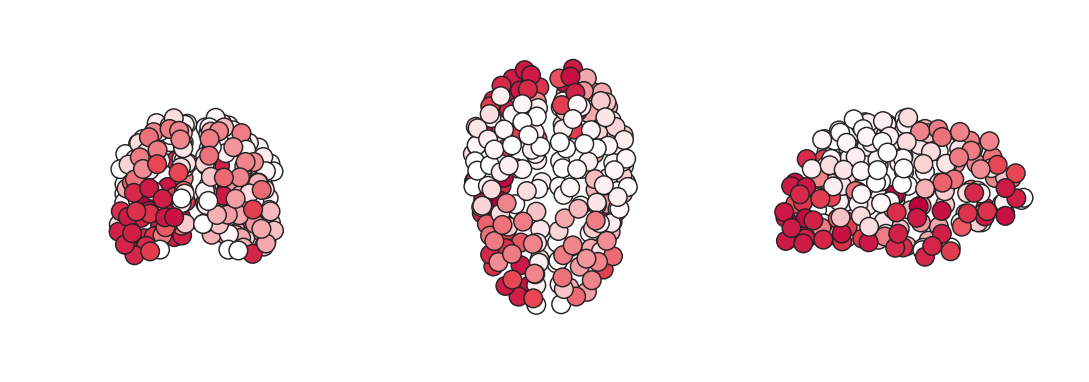

In [126]:
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C"]], figsize=HALF_PAGE, subplot_kw=dict(projection="3d"), dpi=150
)

ut.brain_plotter(
    coreness,
    coordinates,
    axes["A"],
    view=sagittal,
    size=size,
    cmap=white_red_mono,
    scatter_kwargs=scatter_kw,
)
ut.brain_plotter(
    coreness,
    coordinates,
    axes["B"],
    view=axial,
    size=size,
    cmap=white_red_mono,
    scatter_kwargs=scatter_kw,
)
ut.brain_plotter(
    coreness,
    coordinates,
    axes["C"],
    view=coronal,
    size=size,
    cmap=white_red_mono,
    scatter_kwargs=scatter_kw,
)
fig.tight_layout(pad=0.1)

In [127]:
from nctpy.metrics import ave_control
from nctpy.utils import matrix_normalization

a_norm = matrix_normalization(
    consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0], system="discrete"
)
average_controllability = ave_control(connectivity, system="discrete")

SignificanceResult(statistic=0.8620071520787872, pvalue=5.813404073085844e-66)


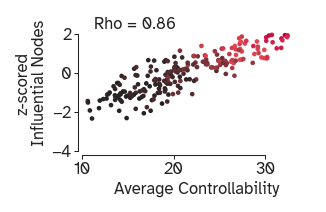

In [128]:
plt.figure(figsize=TINY, dpi=150)
sns.scatterplot(
    x=ut.log_normalize(average_controllability),
    y=influence_zscore,
    s=5,
    hue=influence_gradient.squeeze(),
    palette=black_red_mono,
    linewidth=0,
)
plt.legend().remove()
sns.despine()
plt.xlabel("Average Controllability")
plt.ylabel("z-scored\nInfluential Nodes")
plt.annotate(
    f"Rho = {round(spearmanr(ut.log_normalize(average_controllability),influence_zscore)[0],2)}",
    fontsize=8,
    color=HALF_BLACK,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    xy=(0.05, 0.9),
    xycoords="axes fraction",
)
plt.ylim(-4, 3)
plt.xlim(10, 35)

sns.despine(offset=2, trim=True)
print(spearmanr(ut.log_normalize(average_controllability), influence_zscore))

In [129]:
if HOPF:
    sc_ci_coupling = np.zeros(sliced_modes.shape[1])
    comm_ci_coupling = np.zeros_like(sc_ci_coupling)
    gd_ci_coupling = np.zeros_like(sc_ci_coupling)

    indirect_power = np.zeros_like(sc_ci_coupling)
    direct_power = np.zeros_like(sc_ci_coupling)

    for timepoint in range(sliced_modes.shape[1]):
        lognorm_slice = ut.log_minmax_normalize(sliced_modes[:, timepoint, :])

        indirect_power[timepoint] = np.sum(
            lognorm_slice.flatten()[lognorm_sc.flatten() == 0], axis=0
        )
        direct_power[timepoint] = np.sum(
            lognorm_slice.flatten()[lognorm_sc.flatten() != 0], axis=0
        )

        sc_ci_coupling[timepoint] = cosine(
            lognorm_sc.flatten()[lognorm_sc.flatten() != 0],
            lognorm_slice.flatten()[lognorm_sc.flatten() != 0],
        )
        comm_ci_coupling[timepoint] = cosine(
            lognorm_comm.flatten(), lognorm_slice.flatten()
        )
        gd_ci_coupling[timepoint] = cosine(
            shortest_path_distance.flatten()[lognorm_sc.flatten() == 0],
            lognorm_slice.flatten()[lognorm_sc.flatten() == 0],
        )

In [130]:
if HOPF:
    plt.figure(figsize=TINY, dpi=150)
    plt.plot(comm_ci_coupling, PURPLER)
    plt.plot(sc_ci_coupling, YELLOW)
    plt.ylabel("Cosine Similarity")
    plt.xticks([])
    plt.legend(["CO-CI", "SC-CI"], fontsize=8, bbox_to_anchor=(1, 1), frameon=False)

    sns.despine(offset=1, trim=True, bottom=True)
    #plt.savefig(f"figures/HOPF_CI_sc_coupling.pdf", dpi=600, bbox_inches="tight")

In [131]:
if HOPF:
    smoothed_normalized_direct_power = ut.minmax_normalize(
        pd.DataFrame(direct_power).rolling(20).mean()
    )
    smoothed_normalized_indirect_power = ut.minmax_normalize(
        pd.DataFrame(indirect_power).rolling(20).mean()
    )

In [132]:
if HOPF:
    fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=(18 * CM, 5 * CM), dpi=150)
    axes["A"].plot(smoothed_normalized_direct_power, color=NIGHT_BLUE)
    axes["A"].plot(smoothed_normalized_indirect_power, color=PURPLE)
    sns.despine()
    sns.scatterplot(
        x=ut.minmax_normalize(direct_power),
        y=ut.minmax_normalize(indirect_power),
        s=5,
        alpha=0.5,
        color=HALF_BLACK,
        linewidth=0,
        ax=axes["B"],
        rasterized=True,
    )
    axes["B"].set_xlabel("Direct Power")
    axes["B"].set_ylabel("Indirect Power")

    axes["B"].annotate(
        f"r = {round(pearsonr(direct_power,indirect_power)[0],2)}",
        fontsize=7,
        color=HALF_BLACK,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
        xy=(0.05, 0.9),
        xycoords="axes fraction",
    )

    axes["A"].set_xticks([])
    sns.despine(ax=axes["A"], offset=1, trim=True, bottom=True)
    sns.despine(ax=axes["B"], offset=1, trim=True)
    axes["A"].legend(
        ["Total Direct", "Total Indirect"],
        fontsize=8,
        loc="lower right",
        bbox_to_anchor=(1, -0.1),
        frameon=False,
    )

    print(pearsonr(direct_power, indirect_power))
    #plt.savefig(f"figures/HOPF_CI_over_time.pdf", dpi=600, bbox_inches="tight")